Business Problem: 
It is up to you to define a stakeholder and business problem appropriate to this dataset.

If you are struggling to define a stakeholder, we recommend you complete a project for a real estate agency that helps homeowners buy and/or sell homes. A business problem you could focus on for this stakeholder is the need to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.

Idea: Start by determining which factors matter. Run tests with ~95% confidence intervals, reject null hypotheses when it is appropriate to do so.

Rubric:
https://github.com/learn-co-curriculum/dsc-mod-2-project-v2-1/blob/master/mod2_project_rubric.pdf

Instructions:
https://docs.google.com/document/d/1N7h3-653wXl0BRC59MIMuURyDFX-DVw0uba6P6N7dzw/edit#
https://github.com/learn-co-curriculum/dsc-project-submissions-online

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import json
import requests
import time
from bs4 import BeautifulSoup
import re
from numpy.random import normal
import warnings
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

In [2]:
df_data=pd.read_csv('kc_house_data.csv')

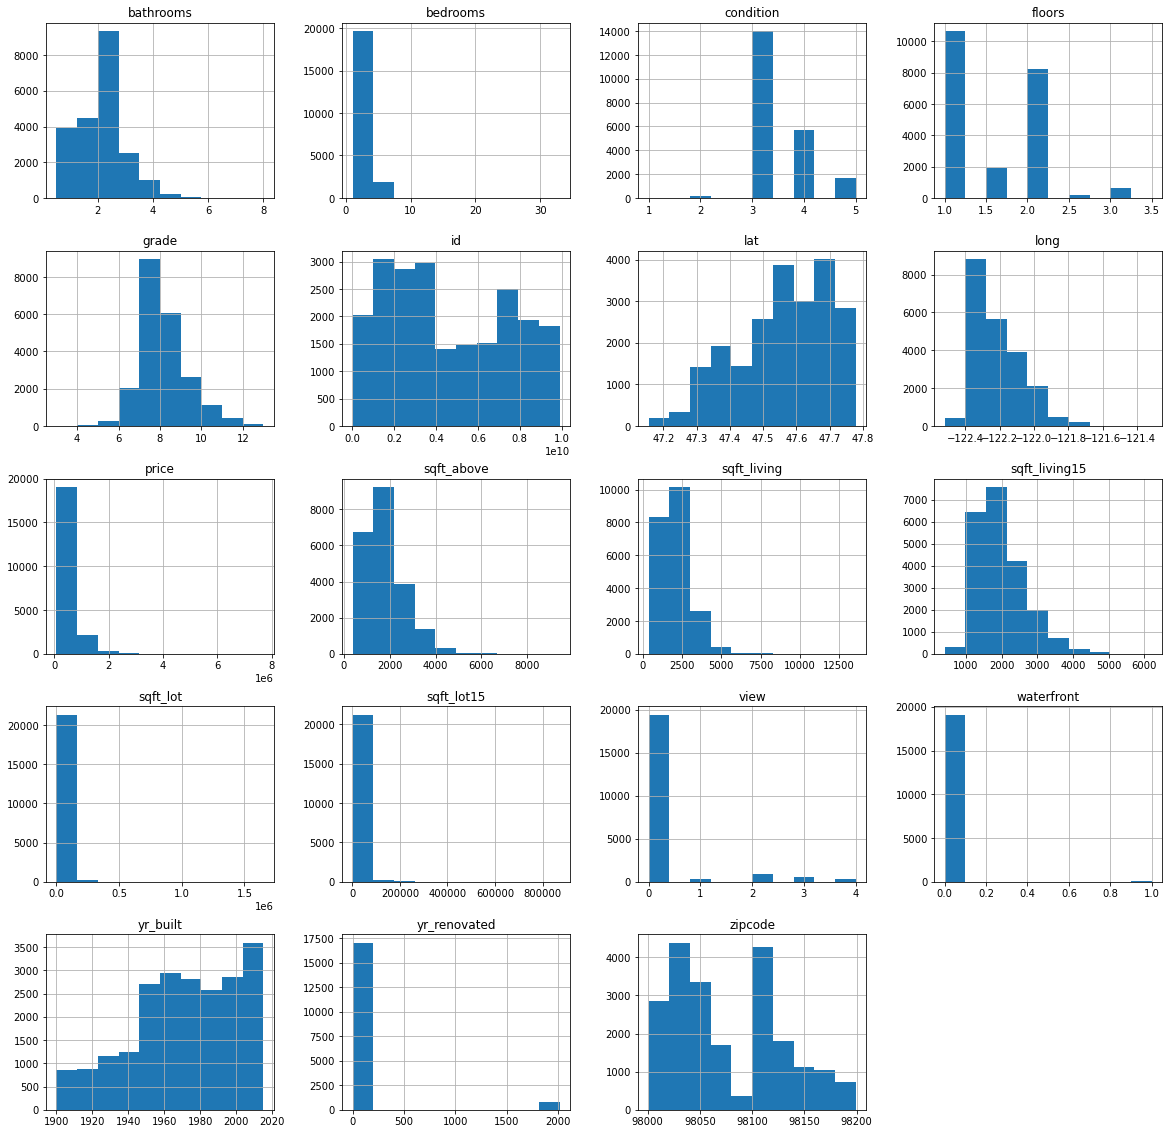

In [3]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
df_data.hist(ax = ax);

First, let's see if we can make any conclusions from the Condition variable, which is one of the categorical ones.

In [4]:
df_data.sort_values(['price','sqft_living'], ascending=[False, False]).head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,...,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800
3910,9808700762,6/11/2014,7060000.0,5,4.5,10040,37325,2.0,1.0,2.0,...,11,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449


In [5]:
df_data.condition.min()

1

In [6]:
df_data.condition.max()

5

In [7]:
df_data.condition.mean()

3.4098254387183404

In [8]:
print(df_data['condition'].describe())

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64


In [9]:
print(df_data['condition'].nunique())

5


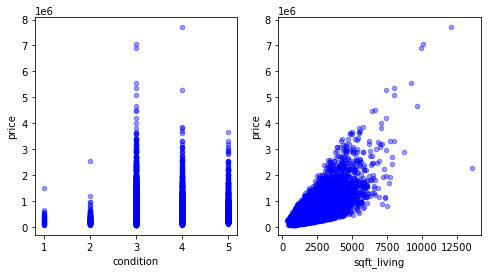

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for xcol, ax in zip(['condition','sqft_living'], axes):
    df_data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

We can see that homes are given a rating of 1-5 depending on how good their condition is. 5 is the best condition, while 1 is the worst. The average home has a rating of 3.41. Do the houses' conditions from our dataset make a difference when determining their final value? Let's observe this further by isolating the houses with condition ratings of 5. 

In [11]:
df_data_good_condition = df_data.loc[df_data.condition == 5]
df_data_good_condition.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3,2487200875,12/9/2014,604000.0,4,3.0,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
25,1202000200,11/3/2014,233000.0,3,2.0,1710,4697,1.5,0.0,0.0,...,6,1710,0.0,1941,0.0,98002,47.3048,-122.218,1030,4705


In [12]:
df_data.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [13]:
df_data_good_condition.price.describe()
#It is helpful to note that sample size of homes with good condition is 1,701.

count    1.701000e+03
mean     6.125777e+05
std      4.113179e+05
min      1.100000e+05
25%      3.500000e+05
50%      5.260000e+05
75%      7.250000e+05
max      3.650000e+06
Name: price, dtype: float64

In [14]:
df_data.sqft_living.mean()

2080.3218502569803

In [15]:
df_data_good_condition.sqft_living.mean()

2022.9112286890065

We can see that on average, the homes with condition scores of 5 are more valuable. But, is that difference statistically significant? We now have the information to make that determination.

In [16]:
#Good (5) condition mean (price): $612,578
#Population mean (price): $540,297
#Population standard deviation: $367,368
#Sample size: 1,701

In [17]:
numerator_condition=612578-540297
numerator_condition

72281

In [18]:
denominator_condition=367368/(1701)**.5
denominator_condition

8907.363322246227

In [19]:
z_score_condition=numerator_condition/denominator_condition
z_score_condition

8.114747022778053

##### Despite the fact that on average, houses with condition ratings of 5 or higher have slightly less square feet, we can conclude with 95% confidence that they are more valuable. Our z-score is 8.11, which is far more than we needed to make this conclusion. It is worth noting that we arrived at this z-score without removing outliers. Outliers tend to increase the standard deviation, meaning they make it less likely that we would reject a null hypothesis. As a result, condition is a variable we will want to include in our model. Let's investigate the number of floors using a similar process.

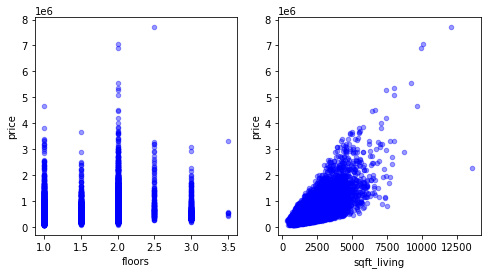

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for xcol, ax in zip(['floors','sqft_living'], axes):
    df_data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

1.5 is very close to the middle of the pack in terms of number of floors. It is a bit hard to tell from our scatter plot, but it looks like there are more valuable homes with 2 floors, even though there are less of them. Let's see a quick correlation matrix consisting of our dependent variable (price), floors, and sqft_living (which we're already nearly certain has a positive impact on price).

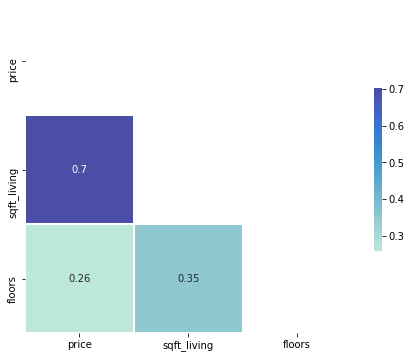

In [21]:
corr = df_data[['price','sqft_living','floors']].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

This matrix leads us to believe that more floors generally means more value. (Also, as expected, the amount of square feet has a strong positive correlation with price.) Let's see if this difference is statistically significant.

In [22]:
df_data.sort_values(['price','floors'], ascending=[False, False]).head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,...,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800
3910,9808700762,6/11/2014,7060000.0,5,4.5,10040,37325,2.0,1.0,2.0,...,11,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449


In [23]:
df_data.floors.min()

1.0

In [24]:
df_data.floors.max()

3.5

In [25]:
df_data.floors.mean()

1.4940964022780943

In [26]:
df_data.floors.median()

1.5

In [27]:
df_data.floors.describe()

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [28]:
#Creating a dataframe consisting of all homes with 2 or more floors.
df_data_2_floors = df_data.loc[df_data.floors >= 2]

In [29]:
df_data_2_floors.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,9.014000e+03,9.014000e+03,9014.000000,9014.000000,9014.000000,9.014000e+03,9014.000000,8047.000000,8988.000000,9014.000000,9014.000000,9014.000000,9014.000000,7454.000000,9014.000000,9014.000000,9014.000000,9014.000000,9014.000000
mean,4.661544e+09,6.522873e+05,3.594520,2.618926,2528.556690,1.535844e+04,2.077879,0.009569,0.254450,3.182938,8.356778,2359.651653,1991.151542,81.979340,98068.895607,47.558777,-122.176562,2281.322720,12940.896716
std,2.921332e+09,4.441065e+05,0.861994,0.630352,990.224943,4.426575e+04,0.260650,0.097357,0.807296,0.466013,1.143465,876.972931,24.559948,396.254237,46.559114,0.133722,0.147888,752.857321,30514.606033
min,1.000102e+06,9.000000e+04,1.000000,0.500000,550.000000,5.720000e+02,2.000000,0.000000,0.000000,1.000000,5.000000,550.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.133010e+09,3.800000e+05,3.000000,2.500000,1810.000000,4.066000e+03,2.000000,0.000000,0.000000,3.000000,8.000000,1730.000000,1987.000000,0.000000,98032.000000,47.479325,-122.304000,1690.000000,4314.000000
50%,3.905100e+09,5.400000e+05,4.000000,2.500000,2390.000000,6.633500e+03,2.000000,0.000000,0.000000,3.000000,8.000000,2260.000000,1999.000000,0.000000,98058.000000,47.574700,-122.182000,2190.000000,6600.000000
75%,7.504101e+09,7.700000e+05,4.000000,2.750000,3060.000000,1.030450e+04,2.000000,0.000000,0.000000,3.000000,9.000000,2860.000000,2006.000000,0.000000,98107.000000,47.667500,-122.056000,2750.000000,9920.000000
max,9.839301e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.024068e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.359000,6210.000000,871200.000000


In [30]:
len(df_data_2_floors)

9014

In [31]:
df_data_2_floors.price.mean()

652287.3035278455

In [32]:
df_data.price.mean()

540296.5735055795

In [33]:
#2+ floors mean (price): $652,287
#Population mean (price): $540,297
#Population standard deviation: $367,368
#Sample size: 9,014

In [34]:
numerator_floors=652287-540297
denominator_floors=367368/(9014)**.5

In [35]:
z_score_floors=numerator_floors/denominator_floors

In [36]:
z_score_floors

28.94254369350173

It certainly seems as though the number of floors should be included in our final model, as they are statistically significant.

Now, before we do any transformations that relate to the distribution of data, let's make sure that our data is sufficient. Our data should be formatted so that it can be fed into a model.

In [37]:
df_data.price.isna().sum()

0

In [38]:
df_data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [39]:
#yr_renovated: Change NaN to 0.
#waterfront: Change NaN to 0.
#view: Change NaN to 0.

In [40]:
df_data['yr_renovated'] = df_data['yr_renovated'].fillna(0)
df_data['waterfront'] = df_data['waterfront'].fillna(0)
df_data['view'] = df_data['view'].fillna(0)

In [41]:
df_data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [42]:
df_data.shape

(21597, 21)

In [43]:
df_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

All columns are in numerical format (integers or floats) except for date and sqft_basement, which may be unnecessary because of the other metrics that relate to square feet. Regardless, we do not know enough yet to conclude that it will not be helpful in our model, so we will want to clean it up.

In [44]:
df_data['sqft_basement']=df_data['sqft_basement'].replace('?',0)

In [45]:
df_data['sqft_basement'] = df_data['sqft_basement'].astype(float)

In [46]:
df_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [47]:
df_data.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [48]:
pd.to_datetime(df_data['date'])

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [49]:
df_data['date']=pd.to_datetime(df_data['date'])

In [50]:
df_data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [51]:
#Note: .summary() and .pvalues can be very helpful. What can we do so that those functions work with our dataset?
#Note: Use R^2 and describe its formal definition.
#Note: Try to alter variables that are not statistically significant so that we can make them significant
#and include them. If we can't alter them so that they are statistically significant, remove them. We do not
#want those in our final model.
#Idea: two-sample t-test, comparing waterfront vs. no waterfront. If it turns out that waterfront
#makes sa significant difference, that could be a good reason to include in the linear regression.

##Train-test split

Time to check for multicollinearity. If the independent variables in our model have high correlations with each other, that can lead to issues.

In [52]:
abs(df_data.corr())>0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [53]:
df = df_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['Pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['Pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
df.columns = ['Correlation']
df.drop_duplicates(inplace=True)
df[(df.Correlation>.75) & (df.Correlation<1)]

,Correlation
Pairs,
"(sqft_above, sqft_living)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(sqft_living, bathrooms)",0.755758


We will need to decide which variables to remove from our model. Sqft_above, sqft_living15, and bathrooms could probably be removed from our model, as these both have a very high correlation with sqft_living. This small dataframe gives us some help. Let's run a regression and see where things stand as it is.

In [54]:
outcome='price'
x_cols=[col for col in df_data.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df_data).fit()
model.summary()
#Investigate: Is being in a particular school district beneficial for price?

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     132.0
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:36   Log-Likelihood:            -2.9411e+05
No. Observations:               21597   AIC:                         5.890e+05
Df Residuals:                   21207   BIC:                         5.921e+05
Df Model:                         389                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  6.86e+06   2.94e+06      2.333      0.020     1.1e+06    1.26e+07
date[T.Timestamp('2014-05-03 00:00:00')]  1.756e+05   1.03e+05      1.702      0.089   -2.66e+04    3.78e+05
date[T.Timestamp('2014-05-04 00:00:00')] -6.548e+04   9.29e+04     -0.705      0.481   -2.48e+05    1.17e+05
date[T.Timestamp('2014-05-05 00:00:00')]  1.645e+04   3.28e+04      0.501      0.616   -4.79e+04    8.08e+04
date[T.Timestamp('2014-05-06 00:00:00')]  -149.1239   3.29e+04     -0.005      0.996   -6.47e+04    6.44e+04
date[T.Timestamp('2014-05-07 00:00:00')]  1.448e+04   3.21e+04      0.451      0.652   -4.85e+04    7.74e+04
date[T.Timestamp('2014-05-08 00:00:00')]  4.844e+04   3.31e+04      1.463      0.143   -1.65e+04    1.13e+05
date[T.Timestamp('2014-05-09 00:00:00')] -1.478e+04   3.31e+04     -0.447      0.655   -7.97e+04    5.01e+04
date[T.Timestamp('2014-05-10 00:00:00')]  3.117e+04    9.3e+04      0.335      0.737   -1.51e+05    2.13e+05
date[T.Timestamp('2014-05-11 00:00:00')]  6.345e+04   1.44e+05      0.441      0.659   -2.19e+05    3.45e+05
date[T.Timestamp('2014-05-12 00:00:00')]  2.123e+04   3.32e+04      0.639      0.523   -4.39e+04    8.63e+04
date[T.Timestamp('2014-05-13 00:00:00')]   4.62e+04   3.27e+04      1.414      0.157   -1.78e+04     1.1e+05
date[T.Timestamp('2014-05-14 00:00:00')]  8128.7981   3.31e+04      0.246      0.806   -5.68e+04     7.3e+04
date[T.Timestamp('2014-05-15 00:00:00')]  6927.0048    3.3e+04      0.210      0.834   -5.78e+04    7.16e+04
date[T.Timestamp('2014-05-16 00:00:00')]  1453.7636   3.39e+04      0.043      0.966    -6.5e+04    6.79e+04
date[T.Timestamp('2014-05-17 00:00:00')]  8.225e+04   2.02e+05      0.407      0.684   -3.14e+05    4.78e+05
date[T.Timestamp('2014-05-18 00:00:00')]  1.944e+04   7.96e+04      0.244      0.807   -1.37e+05    1.76e+05
date[T.Timestamp('2014-05-19 00:00:00')]  1.389e+04   3.29e+04      0.422      0.673   -5.07e+04    7.84e+04
date[T.Timestamp('2014-05-20 00:00:00')]  1.355e+04   3.08e+04      0.440      0.660   -4.67e+04    7.38e+04
date[T.Timestamp('2014-05-21 00:00:00')]  9844.5029   3.21e+04      0.307      0.759    -5.3e+04    7.27e+04
date[T.Timestamp('2014-05-22 00:00:00')]  1.089e+04   3.23e+04      0.338      0.736   -5.24e+04    7.42e+04
date[T.Timestamp('2014-05-23 00:00:00')]  1.244e+04   3.28e+04      0.379      0.705   -5.19e+04    7.68e+04
date[T.Timestamp('2014-05-24 00:00:00')]  5.713e+04   6.53e+04      0.875      0.381   -7.08e+04    1.85e+05
date[T.Timestamp('2014-05-25 00:00:00')] -8.848e+04   9.29e+04     -0.952      0.341   -2.71e+05    9.37e+04
date[T.Timestamp('2014-05-26 00:00:00')] -1.648e+04    7.5e+04     -0.220      0.826   -1.63e+05     1.3e+05
date[T.Timestamp('2014-05-27 00

In [55]:
df_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


There is a lot to clean here. Our initial findings, however, appear to confirm our belief that condition is an important categorical variable to include. We can already see that it has a p-value of 0.000 (statistically significant at a 95% confidence interval, no multicollinearity problems).

One issue is the skewness, which is 3.514 (heavily right-skewed). We can deal with this by removing outliers.

In [56]:
for i in range(90, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, df_data['price'].quantile(q=q)))

0.9 percentile: 887000.0
0.91 percentile: 919993.6
0.92 percentile: 950000.0
0.93 percentile: 997964.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [57]:
len(df_data)

21597

In [58]:
no_outliers=df_data[df_data['price']<=1260000]

In [59]:
len(no_outliers)

20742

Since our data is extremely right-skewed, it may be helpful to remove data with prices in the 96th percentile and above.

In [60]:
outcome='price'
x_cols=[col for col in no_outliers.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
train, test = train_test_split(df_data)
model=ols(formula=formula,data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     101.9
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:38   Log-Likelihood:            -2.2046e+05
No. Observations:               16197   AIC:                         4.417e+05
Df Residuals:                   15810   BIC:                         4.447e+05
Df Model:                         386                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 3.456e+06    3.4e+06      1.017      0.309   -3.21e+06    1.01e+07
date[T.Timestamp('2014-05-03 00:00:00')]  1.717e+05   1.04e+05      1.654      0.098   -3.17e+04    3.75e+05
date[T.Timestamp('2014-05-04 00:00:00')] -6.806e+04   9.37e+04     -0.727      0.467   -2.52e+05    1.16e+05
date[T.Timestamp('2014-05-05 00:00:00')]   675.1862   3.81e+04      0.018      0.986    -7.4e+04    7.54e+04
date[T.Timestamp('2014-05-06 00:00:00')] -1.031e+04    3.8e+04     -0.272      0.786   -8.47e+04    6.41e+04
date[T.Timestamp('2014-05-07 00:00:00')]  1.274e+04   3.71e+04      0.344      0.731      -6e+04    8.54e+04
date[T.Timestamp('2014-05-08 00:00:00')]  3.203e+04   3.84e+04      0.834      0.404   -4.32e+04    1.07e+05
date[T.Timestamp('2014-05-09 00:00:00')] -2.565e+04   3.77e+04     -0.680      0.496   -9.95e+04    4.82e+04
date[T.Timestamp('2014-05-10 00:00:00')]   2.44e+04   1.04e+05      0.235      0.814   -1.79e+05    2.28e+05
date[T.Timestamp('2014-05-11 00:00:00')]  5.893e+04   1.44e+05      0.409      0.682   -2.23e+05    3.41e+05
date[T.Timestamp('2014-05-12 00:00:00')]  2.598e+04   3.76e+04      0.691      0.489   -4.77e+04    9.96e+04
date[T.Timestamp('2014-05-13 00:00:00')]  4.008e+04    3.7e+04      1.084      0.279   -3.24e+04    1.13e+05
date[T.Timestamp('2014-05-14 00:00:00')]  1.527e+04   3.73e+04      0.409      0.682   -5.79e+04    8.84e+04
date[T.Timestamp('2014-05-15 00:00:00')]  1.385e+04   3.77e+04      0.367      0.713   -6.01e+04    8.78e+04
date[T.Timestamp('2014-05-16 00:00:00')] -2.403e+04      4e+04     -0.601      0.548   -1.02e+05    5.43e+04
date[T.Timestamp('2014-05-17 00:00:00')]  7.846e+04   2.02e+05      0.389      0.697   -3.17e+05    4.74e+05
date[T.Timestamp('2014-05-18 00:00:00')]  2.231e+04   8.63e+04      0.259      0.796   -1.47e+05    1.91e+05
date[T.Timestamp('2014-05-19 00:00:00')]   369.0181   3.73e+04      0.010      0.992   -7.28e+04    7.35e+04
date[T.Timestamp('2014-05-20 00:00:00')]  6450.7074   3.54e+04      0.182      0.856    -6.3e+04    7.59e+04
date[T.Timestamp('2014-05-21 00:00:00')]  1842.3022   3.72e+04      0.050      0.961   -7.11e+04    7.48e+04
date[T.Timestamp('2014-05-22 00:00:00')]  2.631e+04   3.74e+04      0.703      0.482   -4.71e+04    9.97e+04
date[T.Timestamp('2014-05-23 00:00:00')]  2.596e+04   3.77e+04      0.689      0.491   -4.79e+04    9.98e+04
date[T.Timestamp('2014-05-24 00:00:00')]  6.596e+04   7.24e+04      0.911      0.362   -7.59e+04    2.08e+05
date[T.Timestamp('2014-05-25 00:00:00')] -9.506e+04   9.37e+04     -1.015      0.310   -2.79e+05    8.86e+04
date[T.Timestamp('2014-05-26 00:00:00')] -5.504e+04   8.06e+04     -0.683      0.495   -2.13e+05    1.03e+05
date[T.Timestamp('2014-05-27 00

That solved our issue with the data being very skewed to the right.

We can consider separating the date field into month and year (integer) columns.

We will also want to remove variables with p-values greater than 0.05, as these are statistically insignificant.

In [61]:
summary = model.summary()
p_table = summary.tables[1]
p_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.456e+06,3.4e+06,1.017,0.309,-3.21e+06,1.01e+07
date[T.Timestamp('2014-05-03 00:00:00')],1.717e+05,1.04e+05,1.654,0.098,-3.17e+04,3.75e+05
date[T.Timestamp('2014-05-04 00:00:00')],-6.806e+04,9.37e+04,-0.727,0.467,-2.52e+05,1.16e+05
date[T.Timestamp('2014-05-05 00:00:00')],675.1862,3.81e+04,0.018,0.986,-7.4e+04,7.54e+04
date[T.Timestamp('2014-05-06 00:00:00')],-1.031e+04,3.8e+04,-0.272,0.786,-8.47e+04,6.41e+04
date[T.Timestamp('2014-05-07 00:00:00')],1.274e+04,3.71e+04,0.344,0.731,-6e+04,8.54e+04
date[T.Timestamp('2014-05-08 00:00:00')],3.203e+04,3.84e+04,0.834,0.404,-4.32e+04,1.07e+05
date[T.Timestamp('2014-05-09 00:00:00')],-2.565e+04,3.77e+04,-0.680,0.496,-9.95e+04,4.82e+04
date[T.Timestamp('2014-05-10 00:00:00')],2.44e+04,1.04e+05,0.235,0.814,-1.79e+05,2.28e+05
date[T.Timestamp('2014-05-11 00:00:00')],5.893e+04,1.44e+05,0.409,0.682,-2.23e+05,3.41e+05


In addition to the multicollinearity issues we noted earlier, sqft_above and sqft_basement also have p-values that are higher than .05. It appears to be very safe to drop these from our model.

In [62]:
df_data['year'] = pd.DatetimeIndex(df_data['date']).year

In [63]:
df_data['month'] = pd.DatetimeIndex(df_data['date']).month

In [64]:
df_data['day'] = pd.DatetimeIndex(df_data['date']).day

In [65]:
df_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,1933,0.0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [66]:
outcome='price'
x_cols=[col for col in no_outliers.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     132.1
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:41   Log-Likelihood:            -2.7188e+05
No. Observations:               20742   AIC:                         5.445e+05
Df Residuals:                   20353   BIC:                         5.476e+05
Df Model:                         388                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                -6.441e+06    1.8e+06     -3.569      0.000   -9.98e+06    -2.9e+06
date[T.Timestamp('2014-05-03 00:00:00')]  1.282e+05    6.2e+04      2.067      0.039    6624.281     2.5e+05
date[T.Timestamp('2014-05-04 00:00:00')]  1.022e+04   5.59e+04      0.183      0.855   -9.93e+04     1.2e+05
date[T.Timestamp('2014-05-05 00:00:00')]  3.921e+04      2e+04      1.956      0.051     -91.019    7.85e+04
date[T.Timestamp('2014-05-06 00:00:00')]  4332.9286   2.01e+04      0.215      0.829   -3.51e+04    4.37e+04
date[T.Timestamp('2014-05-07 00:00:00')]  1.566e+04   1.96e+04      0.797      0.425   -2.28e+04    5.42e+04
date[T.Timestamp('2014-05-08 00:00:00')]  4.271e+04   2.02e+04      2.112      0.035    3075.320    8.23e+04
date[T.Timestamp('2014-05-09 00:00:00')] -1.014e+04   2.03e+04     -0.500      0.617   -4.99e+04    2.96e+04
date[T.Timestamp('2014-05-10 00:00:00')]  5.081e+04   5.59e+04      0.909      0.363   -5.87e+04     1.6e+05
date[T.Timestamp('2014-05-11 00:00:00')]  7.787e+04   8.64e+04      0.901      0.368   -9.16e+04    2.47e+05
date[T.Timestamp('2014-05-12 00:00:00')]  5.859e+04   2.03e+04      2.879      0.004    1.87e+04    9.85e+04
date[T.Timestamp('2014-05-13 00:00:00')]  1.968e+04   2.02e+04      0.976      0.329   -1.98e+04    5.92e+04
date[T.Timestamp('2014-05-14 00:00:00')]  2.049e+04   2.02e+04      1.016      0.309    -1.9e+04       6e+04
date[T.Timestamp('2014-05-15 00:00:00')]   1.48e+04      2e+04      0.738      0.460   -2.45e+04    5.41e+04
date[T.Timestamp('2014-05-16 00:00:00')]  7805.8171   2.07e+04      0.378      0.706   -3.27e+04    4.83e+04
date[T.Timestamp('2014-05-17 00:00:00')]  6.942e+04   1.21e+05      0.572      0.567   -1.68e+05    3.07e+05
date[T.Timestamp('2014-05-18 00:00:00')]   2.69e+04   4.79e+04      0.562      0.574    -6.7e+04    1.21e+05
date[T.Timestamp('2014-05-19 00:00:00')]  1.676e+04   2.01e+04      0.834      0.405   -2.27e+04    5.62e+04
date[T.Timestamp('2014-05-20 00:00:00')]   1.35e+04   1.88e+04      0.718      0.473   -2.34e+04    5.04e+04
date[T.Timestamp('2014-05-21 00:00:00')]  1.033e+04   1.96e+04      0.527      0.598   -2.81e+04    4.87e+04
date[T.Timestamp('2014-05-22 00:00:00')]  2.476e+04   1.96e+04      1.260      0.208   -1.37e+04    6.33e+04
date[T.Timestamp('2014-05-23 00:00:00')]   2.89e+04      2e+04      1.446      0.148   -1.03e+04    6.81e+04
date[T.Timestamp('2014-05-24 00:00:00')]  2.981e+04   4.28e+04      0.696      0.486   -5.41e+04    1.14e+05
date[T.Timestamp('2014-05-25 00:00:00')] -5.736e+04   5.59e+04     -1.027      0.305   -1.67e+05    5.22e+04
date[T.Timestamp('2014-05-26 00:00:00')] -3909.4397   4.51e+04     -0.087      0.931   -9.23e+04    8.45e+04
date[T.Timestamp('2014-05-27 00

In [67]:
x_cols

['id',
 'date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [68]:
p_table_df = pd.DataFrame(p_table.data)

In [69]:
p_table_df.columns=['column','coef','std err','t','P>|t|','0.025','0.975']

In [70]:
p_table_df.drop(labels=0,axis=0,inplace=True)

In [71]:
p_table_df.set_index('column',inplace=True)

In [72]:
p_table_df.head(3)

,coef,std err,t,P>|t|,0.025,0.975
column,,,,,,
Intercept,3.456e+06,3.4e+06,1.017,0.309,-3.21e+06,1.01e+07
date[T.Timestamp('2014-05-03 00:00:00')],1.717e+05,1.04e+05,1.654,0.098,-3.17e+04,3.75e+05
date[T.Timestamp('2014-05-04 00:00:00')],-6.806e+04,9.37e+04,-0.727,0.467,-2.52e+05,1.16e+05


In [73]:
p_table_df['P>|t|'] = p_table_df['P>|t|'].astype(float)

In [74]:
p_table_df['pass05']=p_table_df['P>|t|'].map(lambda x: x<=.05)

In [75]:
p_table_df['pass05']

column
Intercept                                   False
date[T.Timestamp('2014-05-03 00:00:00')]    False
date[T.Timestamp('2014-05-04 00:00:00')]    False
date[T.Timestamp('2014-05-05 00:00:00')]    False
date[T.Timestamp('2014-05-06 00:00:00')]    False
                                            ...  
zipcode                                      True
lat                                          True
long                                         True
sqft_living15                                True
sqft_lot15                                   True
Name: pass05, Length: 388, dtype: bool

In [76]:
pass_list05=list(p_table_df[p_table_df['pass05']==True].index)

In [77]:
#Change . to _. Hyphens would also need to be changed.

In [78]:
df_data.drop(columns=['date'],inplace=True)

In [79]:
df_data.drop(columns=['day'],inplace=True)
#The day field, which we extracted from the date field, does not give us useful information.

In [80]:
outcome='price'
x_cols=[col for col in df_data.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2417.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:42   Log-Likelihood:            -2.9433e+05
No. Observations:               21597   AIC:                         5.887e+05
Df Residuals:                   21575   BIC:                         5.889e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.875e+07   9.93e+06     -6.920      0.000   -8.82e+07   -4.93e+07
id             -1.35e-06   4.81e-07     -2.805      0.005   -2.29e-06   -4.07e-07
bedrooms      -3.608e+04   1895.602    -19.036      0.000   -3.98e+04   -3.24e+04
bathrooms      4.181e+04   3254.042     12.849      0.000    3.54e+04    4.82e+04
sqft_living     103.7089     18.028      5.753      0.000      68.372     139.046
sqft_lot          0.1173      0.048      2.451      0.014       0.023       0.211
floors         7712.3745   3591.571      2.147      0.032     672.630    1.48e+04
waterfront     6.184e+05   1.81e+04     34.187      0.000    5.83e+05    6.54e+05
view           5.311e+04   2117.409     25.083      0.000     4.9e+04    5.73e+04
condition      2.812e+04   2344.531     11.994      0.000    2.35e+04    3.27e+04
grade          9.732e+04   2155.495     45.152      0.000    9.31e+04    1.02e+05
sqft_above       77.0366     18.020      4.275      0.000      41.717     112.357
sqft_basement    47.0400     17.860      2.634      0.008      12.034      82.046
yr_built      -2639.5349     71.739    -36.794      0.000   -2780.148   -2498.922
yr_renovated     24.4477      3.968      6.161      0.000      16.670      32.225
zipcode        -584.1194     32.903    -17.753      0.000    -648.612    -519.627
lat            6.029e+05   1.07e+04     56.284      0.000    5.82e+05    6.24e+05
long          -2.152e+05   1.31e+04    -16.377      0.000   -2.41e+05   -1.89e+05
sqft_living15    21.5876      3.441      6.273      0.000      14.842      28.333
sqft_lot15       -0.4000      0.073     -5.454      0.000      -0.544      -0.256
year           3.751e+04   4703.871      7.975      0.000    2.83e+04    4.67e+04
month          1300.6944    704.828      1.845      0.065     -80.821    2682.210
==============================================================================
Omnibus:                    18410.729   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1879986.481
Skew:                           3.578   Prob(JB):                         0.00
Kurtosis:                      48.144   Cond. No.                     3.93e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
for i in range(90, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, train['price'].quantile(q=q)))

0.9 percentile: 885000.0
0.91 percentile: 915200.5200000003
0.92 percentile: 950000.0
0.93 percentile: 996280.0000000007
0.94 percentile: 1070000.0
0.95 percentile: 1170000.0
0.96 percentile: 1270000.0
0.97 percentile: 1400000.0
0.98 percentile: 1600799.9999999993
0.99 percentile: 1990399.9999999905


In [82]:
for i in range(90, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, df_data['price'].quantile(q=q)))

0.9 percentile: 887000.0
0.91 percentile: 919993.6
0.92 percentile: 950000.0
0.93 percentile: 997964.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [83]:
no_outliers=df_data[df_data['price']<=1260000]

In [84]:
outcome='price'
x_cols=[col for col in df_data.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     2397.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:43   Log-Likelihood:            -2.7214e+05
No. Observations:               20742   AIC:                         5.443e+05
Df Residuals:                   20720   BIC:                         5.445e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.585e+07   6.11e+06     -9.140      0.000   -6.78e+07   -4.39e+07
id            -2.479e-07   2.96e-07     -0.838      0.402   -8.28e-07    3.32e-07
bedrooms      -1.051e+04   1187.308     -8.854      0.000   -1.28e+04   -8184.985
bathrooms      2.429e+04   2047.505     11.862      0.000    2.03e+04    2.83e+04
sqft_living      57.7698     11.921      4.846      0.000      34.404      81.136
sqft_lot          0.2170      0.030      7.224      0.000       0.158       0.276
floors         3.439e+04   2247.789     15.300      0.000       3e+04    3.88e+04
waterfront     1.693e+05   1.61e+04     10.500      0.000    1.38e+05    2.01e+05
view           3.446e+04   1405.172     24.524      0.000    3.17e+04    3.72e+04
condition      2.807e+04   1443.402     19.445      0.000    2.52e+04    3.09e+04
grade          7.775e+04   1356.391     57.322      0.000    7.51e+04    8.04e+04
sqft_above       19.2419     11.888      1.619      0.106      -4.060      42.543
sqft_basement    19.2022     11.801      1.627      0.104      -3.928      42.333
yr_built      -1904.2881     44.967    -42.349      0.000   -1992.426   -1816.150
yr_renovated     17.3621      2.544      6.825      0.000      12.376      22.348
zipcode        -254.0144     20.283    -12.524      0.000    -293.770    -214.259
lat            5.553e+05   6511.310     85.288      0.000    5.43e+05    5.68e+05
long          -6.685e+04   8038.858     -8.316      0.000   -8.26e+04   -5.11e+04
sqft_living15    49.7753      2.254     22.087      0.000      45.358      54.192
sqft_lot15       -0.1573      0.046     -3.429      0.001      -0.247      -0.067
year           2.453e+04   2892.156      8.481      0.000    1.89e+04    3.02e+04
month           534.5252    433.044      1.234      0.217    -314.275    1383.325
==============================================================================
Omnibus:                     2280.737   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4991.487
Skew:                           0.681   Prob(JB):                         0.00
Kurtosis:                       4.979   Cond. No.                     3.95e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
#Next steps: Drop sqft_above, sqft_basement, sqft_living15, sqft_lot15, yr_renovated, zipcode, lat, long, and id.
#Make these into dummy variables: month.

In [86]:
x_cols

['id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'year',
 'month']

In [87]:
new_x_cols=['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
        'condition','grade','yr_built','year','month']

In [88]:
outcome='price'
new_x_cols=[col for col in df_data.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     2397.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:43   Log-Likelihood:            -2.7214e+05
No. Observations:               20742   AIC:                         5.443e+05
Df Residuals:                   20720   BIC:                         5.445e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.585e+07   6.11e+06     -9.140      0.000   -6.78e+07   -4.39e+07
id            -2.479e-07   2.96e-07     -0.838      0.402   -8.28e-07    3.32e-07
bedrooms      -1.051e+04   1187.308     -8.854      0.000   -1.28e+04   -8184.985
bathrooms      2.429e+04   2047.505     11.862      0.000    2.03e+04    2.83e+04
sqft_living      57.7698     11.921      4.846      0.000      34.404      81.136
sqft_lot          0.2170      0.030      7.224      0.000       0.158       0.276
floors         3.439e+04   2247.789     15.300      0.000       3e+04    3.88e+04
waterfront     1.693e+05   1.61e+04     10.500      0.000    1.38e+05    2.01e+05
view           3.446e+04   1405.172     24.524      0.000    3.17e+04    3.72e+04
condition      2.807e+04   1443.402     19.445      0.000    2.52e+04    3.09e+04
grade          7.775e+04   1356.391     57.322      0.000    7.51e+04    8.04e+04
sqft_above       19.2419     11.888      1.619      0.106      -4.060      42.543
sqft_basement    19.2022     11.801      1.627      0.104      -3.928      42.333
yr_built      -1904.2881     44.967    -42.349      0.000   -1992.426   -1816.150
yr_renovated     17.3621      2.544      6.825      0.000      12.376      22.348
zipcode        -254.0144     20.283    -12.524      0.000    -293.770    -214.259
lat            5.553e+05   6511.310     85.288      0.000    5.43e+05    5.68e+05
long          -6.685e+04   8038.858     -8.316      0.000   -8.26e+04   -5.11e+04
sqft_living15    49.7753      2.254     22.087      0.000      45.358      54.192
sqft_lot15       -0.1573      0.046     -3.429      0.001      -0.247      -0.067
year           2.453e+04   2892.156      8.481      0.000    1.89e+04    3.02e+04
month           534.5252    433.044      1.234      0.217    -314.275    1383.325
==============================================================================
Omnibus:                     2280.737   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4991.487
Skew:                           0.681   Prob(JB):                         0.00
Kurtosis:                       4.979   Cond. No.                     3.95e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

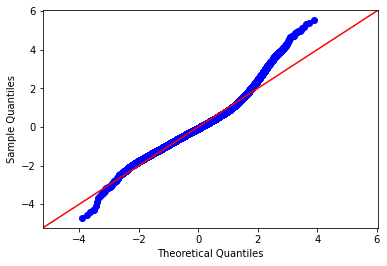

In [89]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [90]:
summary = model.summary()
p_table = summary.tables[1]
p_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.585e+07,6.11e+06,-9.140,0.000,-6.78e+07,-4.39e+07
id,-2.479e-07,2.96e-07,-0.838,0.402,-8.28e-07,3.32e-07
bedrooms,-1.051e+04,1187.308,-8.854,0.000,-1.28e+04,-8184.985
bathrooms,2.429e+04,2047.505,11.862,0.000,2.03e+04,2.83e+04
sqft_living,57.7698,11.921,4.846,0.000,34.404,81.136
sqft_lot,0.2170,0.030,7.224,0.000,0.158,0.276
floors,3.439e+04,2247.789,15.300,0.000,3e+04,3.88e+04
waterfront,1.693e+05,1.61e+04,10.500,0.000,1.38e+05,2.01e+05
view,3.446e+04,1405.172,24.524,0.000,3.17e+04,3.72e+04
condition,2.807e+04,1443.402,19.445,0.000,2.52e+04,3.09e+04


In [91]:
no_outliers.drop(['sqft_living15','sqft_lot15','yr_renovated','zipcode','sqft_above','sqft_basement','id','year','month'], axis=1,inplace=True)

In [92]:
outcome='price'
new_x_cols=[col for col in no_outliers.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     3947.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:44   Log-Likelihood:            -2.7259e+05
No. Observations:               20742   AIC:                         5.452e+05
Df Residuals:                   20729   BIC:                         5.453e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.024e+07   9.28e+05    -21.802      0.000   -2.21e+07   -1.84e+07
bedrooms    -1.054e+04   1208.174     -8.725      0.000   -1.29e+04   -8173.235
bathrooms    2.359e+04   2039.298     11.568      0.000    1.96e+04    2.76e+04
sqft_living    96.2450      2.074     46.402      0.000      92.179     100.310
sqft_lot        0.1385      0.022      6.183      0.000       0.095       0.182
floors       2.963e+04   2024.756     14.635      0.000    2.57e+04    3.36e+04
waterfront   1.706e+05   1.64e+04     10.376      0.000    1.38e+05    2.03e+05
view         3.711e+04   1401.181     26.487      0.000    3.44e+04    3.99e+04
condition     2.62e+04   1441.384     18.176      0.000    2.34e+04     2.9e+04
grade        8.799e+04   1305.361     67.408      0.000    8.54e+04    9.06e+04
yr_built    -1909.2382     43.801    -43.589      0.000   -1995.091   -1823.385
lat          5.366e+05   6407.736     83.740      0.000    5.24e+05    5.49e+05
long         1.673e+04   6987.143      2.394      0.017    3029.800    3.04e+04
==============================================================================
Omnibus:                     2623.534   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6111.474
Skew:                           0.749   Prob(JB):                         0.00
Kurtosis:                       5.197   Cond. No.                     4.62e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared has decreased, but this decrease was expected because we removed quite a few variables. Even variables that are statistically insignicant tend to increase R-squared.

Our data is barely skewed at all by now, with a skew coefficient of .749 (slightly to the right). This is acceptable.

In our newest model, as it stands now, all independent variables are statistically significant.

In [93]:
#Consider: no_outliers.drop(['sqft_lot'], axis=1,inplace=True)

As for sqft_lot, some want a big lot because more potential for an expansion, while others don't want to deal with the space because of more maintenance. Overall, these differences seem to cancel each other out, judging from the p-value. Even though sqft_lot gives us different information than sqft_living, it appears to be statistically insignificant.

In [94]:
outcome='price'
new_x_cols=[col for col in no_outliers.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     3947.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:44   Log-Likelihood:            -2.7259e+05
No. Observations:               20742   AIC:                         5.452e+05
Df Residuals:                   20729   BIC:                         5.453e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.024e+07   9.28e+05    -21.802      0.000   -2.21e+07   -1.84e+07
bedrooms    -1.054e+04   1208.174     -8.725      0.000   -1.29e+04   -8173.235
bathrooms    2.359e+04   2039.298     11.568      0.000    1.96e+04    2.76e+04
sqft_living    96.2450      2.074     46.402      0.000      92.179     100.310
sqft_lot        0.1385      0.022      6.183      0.000       0.095       0.182
floors       2.963e+04   2024.756     14.635      0.000    2.57e+04    3.36e+04
waterfront   1.706e+05   1.64e+04     10.376      0.000    1.38e+05    2.03e+05
view         3.711e+04   1401.181     26.487      0.000    3.44e+04    3.99e+04
condition     2.62e+04   1441.384     18.176      0.000    2.34e+04     2.9e+04
grade        8.799e+04   1305.361     67.408      0.000    8.54e+04    9.06e+04
yr_built    -1909.2382     43.801    -43.589      0.000   -1995.091   -1823.385
lat          5.366e+05   6407.736     83.740      0.000    5.24e+05    5.49e+05
long         1.673e+04   6987.143      2.394      0.017    3029.800    3.04e+04
==============================================================================
Omnibus:                     2623.534   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6111.474
Skew:                           0.749   Prob(JB):                         0.00
Kurtosis:                       5.197   Cond. No.                     4.62e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now, all variables have a .000 p-value and appear to be statistically significant.

In [95]:
#Running a test to see a prediction for a sample house value.
4798000-2754*1970+91.544*2000-15060*2+29630*2+39820*2+127500+0+18240*3+105500*8

690708.0

This is about what we had expected for a house with those characteristics. Still, there is work to do. Next, we will make dummy variables for the categorical variables and try to reduce our condition number, which seems to indicate multicollinearlity.

In [96]:
bins=[0.5,2.50,7.75]
bins_bath=pd.cut(no_outliers['bathrooms'], bins)
bins_bath=bins_bath.cat.as_ordered()
bins_bath.head()

0     (0.5, 2.5]
1     (0.5, 2.5]
2     (0.5, 2.5]
3    (2.5, 7.75]
4     (0.5, 2.5]
Name: bathrooms, dtype: category
Categories (2, interval[float64]): [(0.5, 2.5] < (2.5, 7.75]]

In [97]:
no_outliers.bathrooms=bins_bath
no_outliers.bathrooms=no_outliers.bathrooms.cat.codes
bath_dummies=pd.get_dummies(bins_bath, prefix='bath')
df2=pd.concat([no_outliers,bath_dummies], axis=1)

In [98]:
df2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,lat,long,"bath_(0.5, 2.5]","bath_(2.5, 7.75]"
0,221900.0,3,0,1180,5650,1.0,0.0,0.0,3,7,1955,47.5112,-122.257,1,0
1,538000.0,3,0,2570,7242,2.0,0.0,0.0,3,7,1951,47.7210,-122.319,1,0
2,180000.0,2,0,770,10000,1.0,0.0,0.0,3,6,1933,47.7379,-122.233,1,0
3,604000.0,4,1,1960,5000,1.0,0.0,0.0,5,7,1965,47.5208,-122.393,0,1
4,510000.0,3,0,1680,8080,1.0,0.0,0.0,3,8,1987,47.6168,-122.045,1,0


In [99]:
df2.drop(['bathrooms'], axis=1,inplace=True)

In [100]:
df2.head()

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,lat,long,"bath_(0.5, 2.5]","bath_(2.5, 7.75]"
0,221900.0,3,1180,5650,1.0,0.0,0.0,3,7,1955,47.5112,-122.257,1,0
1,538000.0,3,2570,7242,2.0,0.0,0.0,3,7,1951,47.7210,-122.319,1,0
2,180000.0,2,770,10000,1.0,0.0,0.0,3,6,1933,47.7379,-122.233,1,0
3,604000.0,4,1960,5000,1.0,0.0,0.0,5,7,1965,47.5208,-122.393,0,1
4,510000.0,3,1680,8080,1.0,0.0,0.0,3,8,1987,47.6168,-122.045,1,0


In [101]:
bedrooms_dummies = pd.get_dummies(no_outliers['bedrooms'], prefix='bedr', drop_first=True)
condition_dummies = pd.get_dummies(no_outliers['condition'], prefix='cond', drop_first=True)

In [102]:
data = pd.concat([df2,bedrooms_dummies,condition_dummies], axis=1)

In [103]:
data

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,...,bedr_7,bedr_8,bedr_9,bedr_10,bedr_11,bedr_33,cond_2,cond_3,cond_4,cond_5
0,221900.0,3,1180,5650,1.0,0.0,0.0,3,7,1955,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,3,2570,7242,2.0,0.0,0.0,3,7,1951,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,2,770,10000,1.0,0.0,0.0,3,6,1933,...,0,0,0,0,0,0,0,1,0,0
3,604000.0,4,1960,5000,1.0,0.0,0.0,5,7,1965,...,0,0,0,0,0,0,0,0,0,1
4,510000.0,3,1680,8080,1.0,0.0,0.0,3,8,1987,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,1530,1131,3.0,0.0,0.0,3,8,2009,...,0,0,0,0,0,0,0,1,0,0
21593,400000.0,4,2310,5813,2.0,0.0,0.0,3,8,2014,...,0,0,0,0,0,0,0,1,0,0
21594,402101.0,2,1020,1350,2.0,0.0,0.0,3,7,2009,...,0,0,0,0,0,0,0,1,0,0
21595,400000.0,3,1600,2388,2.0,0.0,0.0,3,8,2004,...,0,0,0,0,0,0,0,1,0,0


In [104]:
data.columns=data.columns.map(lambda x: x.replace('.','_').replace(',','_').replace('[','').replace(']','').replace('(','').replace(')',''))

In [105]:
data.head()

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,...,bedr_7,bedr_8,bedr_9,bedr_10,bedr_11,bedr_33,cond_2,cond_3,cond_4,cond_5
0,221900.0,3,1180,5650,1.0,0.0,0.0,3,7,1955,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,3,2570,7242,2.0,0.0,0.0,3,7,1951,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,2,770,10000,1.0,0.0,0.0,3,6,1933,...,0,0,0,0,0,0,0,1,0,0
3,604000.0,4,1960,5000,1.0,0.0,0.0,5,7,1965,...,0,0,0,0,0,0,0,0,0,1
4,510000.0,3,1680,8080,1.0,0.0,0.0,3,8,1987,...,0,0,0,0,0,0,0,1,0,0


In [106]:
data.rename(columns={'bath_0_5_ 2_5': 'bath_low'},inplace=True)
data.rename(columns={'bath_2_5_ 7_75': 'bath_high'},inplace=True)

In [107]:
outcome='price'
new_x_cols=[col for col in data.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1825.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:44   Log-Likelihood:            -2.7257e+05
No. Observations:               20742   AIC:                         5.452e+05
Df Residuals:                   20715   BIC:                         5.454e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.961e+07   9.04e+05    -21.689      0.000   -2.14e+07   -1.78e+07
bedrooms    -1.482e+04   3123.119     -4.747      0.000   -2.09e+04   -8702.503
sqft_living   100.3771      1.992     50.399      0.000      96.473     104.281
sqft_lot        0.1261      0.022      5.626      0.000       0.082       0.170
floors       3.392e+04   1980.520     17.125      0.000       3e+04    3.78e+04
waterfront   1.711e+05   1.64e+04     10.402      0.000    1.39e+05    2.03e+05
view         3.705e+04   1401.488     26.436      0.000    3.43e+04    3.98e+04
condition   -6.109e+05   2.99e+04    -20.412      0.000    -6.7e+05   -5.52e+05
grade        8.877e+04   1316.976     67.405      0.000    8.62e+04    9.14e+04
yr_built    -1758.3225     42.038    -41.827      0.000   -1840.720   -1675.925
lat          5.349e+05   6436.893     83.094      0.000    5.22e+05    5.47e+05
long         1.872e+04   7014.209      2.668      0.008    4967.991    3.25e+04
bath_low       7.8e+04   6.17e+04      1.264      0.206    -4.3e+04    1.99e+05
bath_high    1.106e+05   6.18e+04      1.790      0.073   -1.05e+04    2.32e+05
bedr_2       2117.9724   9150.631      0.231      0.817   -1.58e+04    2.01e+04
bedr_3       2199.7641      1e+04      0.219      0.826   -1.75e+04    2.19e+04
bedr_4       1.217e+04   1.19e+04      1.020      0.308   -1.12e+04    3.55e+04
bedr_5       1.385e+04   1.45e+04      0.957      0.339   -1.45e+04    4.22e+04
bedr_6       1.139e+04   1.84e+04      0.620      0.535   -2.46e+04    4.74e+04
bedr_7      -2.459e+04   2.87e+04     -0.855      0.392   -8.09e+04    3.18e+04
bedr_8       7442.4669   4.54e+04      0.164      0.870   -8.16e+04    9.65e+04
bedr_9       3.328e+04    6.4e+04      0.520      0.603   -9.21e+04    1.59e+05
bedr_10      1.644e+05   7.26e+04      2.263      0.024     2.2e+04    3.07e+05
bedr_11     -1.321e+04   1.18e+05     -0.112      0.911   -2.45e+05    2.19e+05
bedr_33      5.599e+05   5.33e+04     10.510      0.000    4.55e+05    6.64e+05
cond_2       6.321e+05   3.48e+04     18.144      0.000    5.64e+05       7e+05
cond_3       1.259e+06    5.9e+04     21.332      0.000    1.14e+06    1.37e+06
cond_4       1.896e+06   8.75e+04     21.662      0.000    1.72e+06    2.07e+06
cond_5       2.539e+06   1.17e+05     21.754      0.000    2.31e+06    2.77e+06
==============================================================================
Omnibus:                     2593.629   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5964.794
Skew:                           0.745   Prob(JB):                         0.00
Kurtosis:                       5.163   Cond. No.                     1.09e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the co

In [108]:
data.describe()

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,...,bedr_7,bedr_8,bedr_9,bedr_10,bedr_11,bedr_33,cond_2,cond_3,cond_4,cond_5
count,2.074200e+04,20742.000000,20742.000000,2.074200e+04,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,...,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000
mean,4.871982e+05,3.340999,1997.125108,1.468612e+04,1.480233,0.002989,0.184167,3.406663,7.559396,1970.867949,...,0.001543,0.000434,0.000193,0.000145,0.000048,0.000048,0.008148,0.649552,0.264391,0.076560
std,2.236077e+05,0.912421,797.480005,4.005326e+04,0.536993,0.054592,0.666459,0.647165,1.062901,29.202482,...,0.039249,0.020826,0.013886,0.012026,0.006943,0.006943,0.089898,0.477122,0.441019,0.265898
min,7.800000e+04,1.000000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.170000e+05,3.000000,1400.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.400000e+05,3.000000,1870.000000,7.520000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1974.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.125000e+05,4.000000,2460.000000,1.040000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.260000e+06,33.000000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,2015.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
bins=[1.00,3.00,33]
bins_bedrooms=pd.cut(data['bedrooms'], bins)
bins_bedrooms=bins_bedrooms.cat.as_ordered()
bins_bedrooms.head()

0     (1.0, 3.0]
1     (1.0, 3.0]
2     (1.0, 3.0]
3    (3.0, 33.0]
4     (1.0, 3.0]
Name: bedrooms, dtype: category
Categories (2, interval[float64]): [(1.0, 3.0] < (3.0, 33.0]]

In [110]:
data.bedrooms=bins_bedrooms
data.bedrooms=data.bedrooms.cat.codes
bedr_dummies=pd.get_dummies(bins_bedrooms, prefix='bedr')

In [111]:
df3=pd.concat([data,bedr_dummies], axis=1)
df3.drop(['bedrooms'], axis=1,inplace=True)

In [112]:
df3.columns=df3.columns.map(lambda x: x.replace('.','_').replace(',','_').replace('[','').replace(']','').replace('(','').replace(')',''))

In [113]:
df3.rename(columns={'bedr_3_0_ 33_0': 'bedr_high'},inplace=True)
df3.rename(columns={'bedr_1_0_ 3_0': 'bedr_low'},inplace=True)

In [114]:
df3.drop(['bedr_2','bedr_3','bedr_4','bedr_5','bedr_6','bedr_7','bedr_8','bedr_9',
               'bedr_10','bedr_11','bedr_33'],axis=1,inplace=True)

In [115]:
outcome='price'
new_x_cols=[col for col in df3.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     2780.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:45   Log-Likelihood:            -2.7260e+05
No. Observations:               20742   AIC:                         5.452e+05
Df Residuals:                   20724   BIC:                         5.454e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.962e+07   9.04e+05    -21.712      0.000   -2.14e+07   -1.78e+07
sqft_living    96.2249      1.919     50.154      0.000      92.464      99.985
sqft_lot        0.1341      0.022      5.980      0.000       0.090       0.178
floors       3.426e+04   1980.700     17.296      0.000    3.04e+04    3.81e+04
waterfront    1.73e+05   1.65e+04     10.510      0.000    1.41e+05    2.05e+05
view         3.744e+04   1402.350     26.697      0.000    3.47e+04    4.02e+04
condition   -6.122e+05   2.99e+04    -20.468      0.000   -6.71e+05   -5.54e+05
grade        8.994e+04   1303.488     69.002      0.000    8.74e+04    9.25e+04
yr_built    -1767.1777     41.895    -42.181      0.000   -1849.296   -1685.060
lat          5.365e+05   6427.031     83.475      0.000    5.24e+05    5.49e+05
long         1.918e+04   7009.974      2.735      0.006    5435.047    3.29e+04
bath_low     7.223e+04   6.18e+04      1.169      0.243   -4.89e+04    1.93e+05
bath_high    1.029e+05   6.19e+04      1.663      0.096   -1.84e+04    2.24e+05
cond_2       6.321e+05   3.48e+04     18.139      0.000    5.64e+05       7e+05
cond_3       1.259e+06    5.9e+04     21.340      0.000    1.14e+06    1.37e+06
cond_4       1.897e+06   8.75e+04     21.679      0.000    1.73e+06    2.07e+06
cond_5       2.541e+06   1.17e+05     21.783      0.000    2.31e+06    2.77e+06
bedr_low    -2.188e+04   9006.518     -2.429      0.015   -3.95e+04   -4223.601
bedr_high   -3.025e+04   9237.546     -3.274      0.001   -4.84e+04   -1.21e+04
==============================================================================
Omnibus:                     2573.775   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5933.387
Skew:                           0.740   Prob(JB):                         0.00
Kurtosis:                       5.163   Cond. No.                     3.48e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.12e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

It appears that bedr_high (all homes with more than 3 bedrooms fall into this category) has a negative impact on price. Let's see what happens when we remove this variable, as having both this and bedr_low in our model could cause problems.

In [116]:
df4=df3

In [117]:
#df4.drop(['bath_low'], axis=1,inplace=True)

In [118]:
outcome='price'
new_x_cols=[col for col in df4.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df4).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     2780.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:45   Log-Likelihood:            -2.7260e+05
No. Observations:               20742   AIC:                         5.452e+05
Df Residuals:                   20724   BIC:                         5.454e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.962e+07   9.04e+05    -21.712      0.000   -2.14e+07   -1.78e+07
sqft_living    96.2249      1.919     50.154      0.000      92.464      99.985
sqft_lot        0.1341      0.022      5.980      0.000       0.090       0.178
floors       3.426e+04   1980.700     17.296      0.000    3.04e+04    3.81e+04
waterfront    1.73e+05   1.65e+04     10.510      0.000    1.41e+05    2.05e+05
view         3.744e+04   1402.350     26.697      0.000    3.47e+04    4.02e+04
condition   -6.122e+05   2.99e+04    -20.468      0.000   -6.71e+05   -5.54e+05
grade        8.994e+04   1303.488     69.002      0.000    8.74e+04    9.25e+04
yr_built    -1767.1777     41.895    -42.181      0.000   -1849.296   -1685.060
lat          5.365e+05   6427.031     83.475      0.000    5.24e+05    5.49e+05
long         1.918e+04   7009.974      2.735      0.006    5435.047    3.29e+04
bath_low     7.223e+04   6.18e+04      1.169      0.243   -4.89e+04    1.93e+05
bath_high    1.029e+05   6.19e+04      1.663      0.096   -1.84e+04    2.24e+05
cond_2       6.321e+05   3.48e+04     18.139      0.000    5.64e+05       7e+05
cond_3       1.259e+06    5.9e+04     21.340      0.000    1.14e+06    1.37e+06
cond_4       1.897e+06   8.75e+04     21.679      0.000    1.73e+06    2.07e+06
cond_5       2.541e+06   1.17e+05     21.783      0.000    2.31e+06    2.77e+06
bedr_low    -2.188e+04   9006.518     -2.429      0.015   -3.95e+04   -4223.601
bedr_high   -3.025e+04   9237.546     -3.274      0.001   -4.84e+04   -1.21e+04
==============================================================================
Omnibus:                     2573.775   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5933.387
Skew:                           0.740   Prob(JB):                         0.00
Kurtosis:                       5.163   Cond. No.                     3.48e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.12e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [119]:
df5=df4

In [120]:
#df5.drop(['bedr_high'], axis=1,inplace=True)

In [121]:
outcome='price'
new_x_cols=[col for col in df5.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df5).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     2780.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:46   Log-Likelihood:            -2.7260e+05
No. Observations:               20742   AIC:                         5.452e+05
Df Residuals:                   20724   BIC:                         5.454e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.962e+07   9.04e+05    -21.712      0.000   -2.14e+07   -1.78e+07
sqft_living    96.2249      1.919     50.154      0.000      92.464      99.985
sqft_lot        0.1341      0.022      5.980      0.000       0.090       0.178
floors       3.426e+04   1980.700     17.296      0.000    3.04e+04    3.81e+04
waterfront    1.73e+05   1.65e+04     10.510      0.000    1.41e+05    2.05e+05
view         3.744e+04   1402.350     26.697      0.000    3.47e+04    4.02e+04
condition   -6.122e+05   2.99e+04    -20.468      0.000   -6.71e+05   -5.54e+05
grade        8.994e+04   1303.488     69.002      0.000    8.74e+04    9.25e+04
yr_built    -1767.1777     41.895    -42.181      0.000   -1849.296   -1685.060
lat          5.365e+05   6427.031     83.475      0.000    5.24e+05    5.49e+05
long         1.918e+04   7009.974      2.735      0.006    5435.047    3.29e+04
bath_low     7.223e+04   6.18e+04      1.169      0.243   -4.89e+04    1.93e+05
bath_high    1.029e+05   6.19e+04      1.663      0.096   -1.84e+04    2.24e+05
cond_2       6.321e+05   3.48e+04     18.139      0.000    5.64e+05       7e+05
cond_3       1.259e+06    5.9e+04     21.340      0.000    1.14e+06    1.37e+06
cond_4       1.897e+06   8.75e+04     21.679      0.000    1.73e+06    2.07e+06
cond_5       2.541e+06   1.17e+05     21.783      0.000    2.31e+06    2.77e+06
bedr_low    -2.188e+04   9006.518     -2.429      0.015   -3.95e+04   -4223.601
bedr_high   -3.025e+04   9237.546     -3.274      0.001   -4.84e+04   -1.21e+04
==============================================================================
Omnibus:                     2573.775   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5933.387
Skew:                           0.740   Prob(JB):                         0.00
Kurtosis:                       5.163   Cond. No.                     3.48e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.12e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

It appears that surprisingly, bedr_low (pertains to houses with between 1 and 3 bedrooms) has a positive impact on price. While this is statistically significant, the impact is not as large in magnitude as most other variables.

In [122]:
df6=df5
df6.drop(['cond_2','cond_3','cond_4'], axis=1,inplace=True)
outcome='price'
new_x_cols=[col for col in df6.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df6).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     3150.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:46   Log-Likelihood:            -2.7260e+05
No. Observations:               20742   AIC:                         5.452e+05
Df Residuals:                   20726   BIC:                         5.454e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.022e+07   9.32e+05    -21.696      0.000   -2.21e+07   -1.84e+07
sqft_living    96.2370      1.918     50.165      0.000      92.477      99.997
sqft_lot        0.1353      0.022      6.042      0.000       0.091       0.179
floors       3.414e+04   1978.075     17.257      0.000    3.03e+04     3.8e+04
waterfront   1.731e+05   1.65e+04     10.519      0.000    1.41e+05    2.05e+05
view         3.743e+04   1402.268     26.695      0.000    3.47e+04    4.02e+04
condition    2.485e+04   1990.056     12.487      0.000    2.09e+04    2.88e+04
grade        8.987e+04   1301.954     69.026      0.000    8.73e+04    9.24e+04
yr_built    -1773.3011     41.595    -42.632      0.000   -1854.831   -1691.771
lat          5.362e+05   6420.726     83.505      0.000    5.24e+05    5.49e+05
long         1.932e+04   7008.857      2.756      0.006    5580.887    3.31e+04
bath_low     7.272e+04   6.18e+04      1.177      0.239   -4.84e+04    1.94e+05
bath_high    1.034e+05   6.19e+04      1.671      0.095   -1.79e+04    2.25e+05
cond_5       7156.5219   4607.602      1.553      0.120   -1874.739    1.62e+04
bedr_low    -2.226e+04   8999.724     -2.473      0.013   -3.99e+04   -4620.480
bedr_high    -3.06e+04   9231.520     -3.315      0.001   -4.87e+04   -1.25e+04
==============================================================================
Omnibus:                     2579.899   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5952.388
Skew:                           0.741   Prob(JB):                         0.00
Kurtosis:                       5.166   Cond. No.                     4.64e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

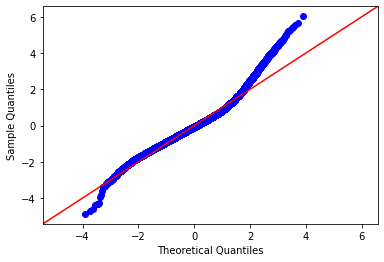

In [123]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [124]:
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression

#make X,y to put in the train-test split
#y=df6.price
#X=df6.drop('price', axis=1)

In [125]:
#X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [126]:
#linreg=LinearRegression()
#linreg.fit(X_train, y_train)

#y_hat_train=linreg.predict(X_train)
#y_hat_test=linreg.predict(X_test)

In [127]:
#y_hat_test

In [128]:
#y_test

In [129]:
#train_mse=mean_squared_error(y_train, y_hat_train)
#test_mse=mean_squared_error(y_test, y_hat_test)

#print('Train Mean Squared Error {}'.format(train_mse))
#print('Test Mean Squared Error {}'.format(test_mse))
#print('Root Train Mean Squared Error {}'.format(train_mse**0.5))
#print('Root Test Mean Squared Error {}'.format(test_mse**0.5))

After working on outliers, data cleaning, dummy valiables, and initial iterations of our model, we made a new csv that is easier to work with.

In [130]:
#outcome='price'
#x_cols=df.drop('price',axis=1)

In [131]:
#predictors = '+'.join(x_cols)
#formula = outcome + "~" + predictors
#model = ols(formula=formula, data=df).fit()
#model.summary()

In [132]:
#remove the variables with p-values higher than 0.05
#summary=model.summary()
#p_table = summary.tables[1]
#p_table = pd.DataFrame(p_table.data)
#p_table.columns = p_table.iloc[0]
#p_table = p_table.drop(0)
#p_table = p_table.set_index(p_table.columns[0])
#p_table['P>|t|'] = p_table['P>|t|'].astype(float)
#x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
#x_cols.remove('Intercept')
#print(len(p_table), len(x_cols))
#print(x_cols[:5])
#p_table.head()

In [133]:
# Refit model with subset features
#predictors = '+'.join(x_cols)
#formula = outcome + "~" + predictors
#model = ols(formula=formula, data=df).fit()
#model.summary()

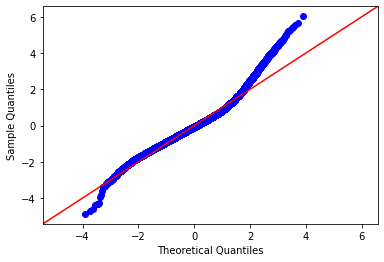

In [134]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [135]:
outcome='price'
new_x_cols=[col for col in df6.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df6).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     3150.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:47   Log-Likelihood:            -2.7260e+05
No. Observations:               20742   AIC:                         5.452e+05
Df Residuals:                   20726   BIC:                         5.454e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.022e+07   9.32e+05    -21.696      0.000   -2.21e+07   -1.84e+07
sqft_living    96.2370      1.918     50.165      0.000      92.477      99.997
sqft_lot        0.1353      0.022      6.042      0.000       0.091       0.179
floors       3.414e+04   1978.075     17.257      0.000    3.03e+04     3.8e+04
waterfront   1.731e+05   1.65e+04     10.519      0.000    1.41e+05    2.05e+05
view         3.743e+04   1402.268     26.695      0.000    3.47e+04    4.02e+04
condition    2.485e+04   1990.056     12.487      0.000    2.09e+04    2.88e+04
grade        8.987e+04   1301.954     69.026      0.000    8.73e+04    9.24e+04
yr_built    -1773.3011     41.595    -42.632      0.000   -1854.831   -1691.771
lat          5.362e+05   6420.726     83.505      0.000    5.24e+05    5.49e+05
long         1.932e+04   7008.857      2.756      0.006    5580.887    3.31e+04
bath_low     7.272e+04   6.18e+04      1.177      0.239   -4.84e+04    1.94e+05
bath_high    1.034e+05   6.19e+04      1.671      0.095   -1.79e+04    2.25e+05
cond_5       7156.5219   4607.602      1.553      0.120   -1874.739    1.62e+04
bedr_low    -2.226e+04   8999.724     -2.473      0.013   -3.99e+04   -4620.480
bedr_high    -3.06e+04   9231.520     -3.315      0.001   -4.87e+04   -1.25e+04
==============================================================================
Omnibus:                     2579.899   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5952.388
Skew:                           0.741   Prob(JB):                         0.00
Kurtosis:                       5.166   Cond. No.                     4.64e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(1) On the newest model, R-squared is still lower than we would like it to be, but it still indicates that our model explains 59.6% of the variation of our dependent variable (price) can be explained by variation in our independent variables. (2) Root Mean Squared Error is high, about 140,000. (3) QQ plot still has a slight head and tail (outliers) but appears to be satisfactory.

Try cross-validation? No clear limit on how many times we should do train-test.

In [136]:
df7=df6

In [137]:
#Getting rid of condition because we already have a
#dummy variable that indicates if a home was given a condition of 5.
df7.drop(['condition'], axis=1,inplace=True)

In [138]:
outcome='price'
new_x_cols=[col for col in df7.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df7).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     3339.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:47   Log-Likelihood:            -2.7268e+05
No. Observations:               20742   AIC:                         5.454e+05
Df Residuals:                   20727   BIC:                         5.455e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -1.94e+07   9.33e+05    -20.787      0.000   -2.12e+07   -1.76e+07
sqft_living    96.9506      1.925     50.371      0.000      93.178     100.723
sqft_lot        0.1327      0.022      5.905      0.000       0.089       0.177
floors       3.051e+04   1963.933     15.535      0.000    2.67e+04    3.44e+04
waterfront   1.742e+05   1.65e+04     10.546      0.000    1.42e+05    2.07e+05
view         3.753e+04   1407.476     26.667      0.000    3.48e+04    4.03e+04
grade        9.008e+04   1306.697     68.939      0.000    8.75e+04    9.26e+04
yr_built    -1868.7626     41.039    -45.536      0.000   -1949.203   -1788.323
lat            5.3e+05   6425.882     82.485      0.000    5.17e+05    5.43e+05
long         2.151e+04   7032.793      3.059      0.002    7726.617    3.53e+04
bath_low     7.445e+04    6.2e+04      1.200      0.230   -4.71e+04    1.96e+05
bath_high    1.043e+05   6.21e+04      1.679      0.093   -1.74e+04    2.26e+05
cond_5        4.69e+04   3344.374     14.022      0.000    4.03e+04    5.35e+04
bedr_low    -1.684e+04   9022.770     -1.866      0.062   -3.45e+04     847.894
bedr_high   -2.474e+04   9253.980     -2.674      0.008   -4.29e+04   -6606.409
==============================================================================
Omnibus:                     2558.012   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5904.569
Skew:                           0.735   Prob(JB):                         0.00
Kurtosis:                       5.161   Cond. No.                     4.63e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

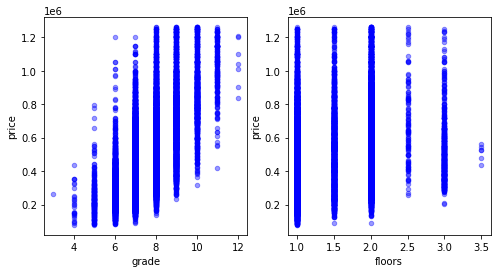

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for xcol, ax in zip(['grade','floors'], axes):
    df7.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

As grade and floors are categorical, we will want to split these up into dummy variables as we did for bedrooms and bathrooms.

Grade: Overall grade given to the housing unit, based on King County grading system.

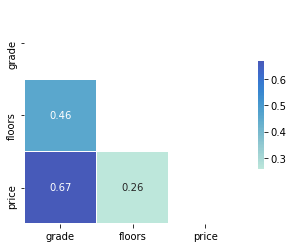

In [140]:
corr = df_data[['grade','floors','price']].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(6, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

Judging from our model and the correlations, it certainly seems that a higher grade is a good thing. Let's observe this variable further, along with floors.

In [141]:
#pd.plotting.scatter_matrix(df7, alpha=0.5, figsize=(30,20))
#plt.show()

In [142]:
bins=[3,7,12]
bins_grade=pd.cut(df7['grade'], bins)
bins_grade=bins_grade.cat.as_ordered()
bins_grade.head()

0     (3, 7]
1     (3, 7]
2     (3, 7]
3     (3, 7]
4    (7, 12]
Name: grade, dtype: category
Categories (2, interval[int64]): [(3, 7] < (7, 12]]

In [143]:
df7.grade=bins_grade
df7.grade=df7.grade.cat.codes
grade_dummies=pd.get_dummies(bins_grade, prefix='grade')
df8=pd.concat([df7,grade_dummies], axis=1)

In [144]:
#df8.drop(['grade'], axis=1,inplace=True)

In [145]:
df8.rename(columns={'grade_(3, 7]': 'grade_low'},inplace=True)
df8.rename(columns={'grade_(7, 12]': 'grade_high'},inplace=True)
df8.head()

,price,sqft_living,sqft_lot,floors,waterfront,view,grade,yr_built,lat,long,bath_low,bath_high,cond_5,bedr_low,bedr_high,grade_low,grade_high
0,221900.0,1180,5650,1.0,0.0,0.0,0,1955,47.5112,-122.257,1,0,0,1,0,1,0
1,538000.0,2570,7242,2.0,0.0,0.0,0,1951,47.7210,-122.319,1,0,0,1,0,1,0
2,180000.0,770,10000,1.0,0.0,0.0,0,1933,47.7379,-122.233,1,0,0,1,0,1,0
3,604000.0,1960,5000,1.0,0.0,0.0,0,1965,47.5208,-122.393,0,1,1,0,1,1,0
4,510000.0,1680,8080,1.0,0.0,0.0,1,1987,47.6168,-122.045,1,0,0,1,0,0,1


In [146]:
outcome='price'
new_x_cols=[col for col in df8.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df8).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     2615.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:48   Log-Likelihood:            -2.7391e+05
No. Observations:               20742   AIC:                         5.478e+05
Df Residuals:                   20726   BIC:                         5.480e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.975e+07   8.47e+05    -23.309      0.000   -2.14e+07   -1.81e+07
sqft_living   142.7738      1.811     78.839      0.000     139.224     146.323
sqft_lot        0.1412      0.024      5.922      0.000       0.094       0.188
floors       3.457e+04   2100.067     16.460      0.000    3.05e+04    3.87e+04
waterfront   1.577e+05   1.75e+04      8.999      0.000    1.23e+05    1.92e+05
view         3.982e+04   1494.461     26.643      0.000    3.69e+04    4.27e+04
grade        3.249e+06   1.58e+05     20.515      0.000    2.94e+06    3.56e+06
yr_built    -1489.0334     42.851    -34.749      0.000   -1573.025   -1405.042
lat          5.702e+05   6767.437     84.260      0.000    5.57e+05    5.83e+05
long         8827.1982   7457.994      1.184      0.237   -5791.055    2.34e+04
bath_low     1.199e+05   6.58e+04      1.823      0.068   -9053.169    2.49e+05
bath_high    1.483e+05   6.59e+04      2.252      0.024    1.92e+04    2.77e+05
cond_5       4.203e+04   3548.206     11.845      0.000    3.51e+04     4.9e+04
bedr_low     1.607e+04   9590.758      1.675      0.094   -2733.284    3.49e+04
bedr_high   -2659.0979   9843.569     -0.270      0.787    -2.2e+04    1.66e+04
grade_low   -3.404e+06   1.53e+05    -22.230      0.000    -3.7e+06    -3.1e+06
grade_high  -6.546e+06   2.82e+05    -23.176      0.000    -7.1e+06   -5.99e+06
==============================================================================
Omnibus:                     2173.043   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4568.079
Skew:                           0.666   Prob(JB):                         0.00
Kurtosis:                       4.874   Cond. No.                     1.97e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.73e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [147]:
df8.drop(columns=['grade_low'],inplace=True)

In [148]:
outcome='price'
new_x_cols=[col for col in df8.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df8).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     2615.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:49   Log-Likelihood:            -2.7391e+05
No. Observations:               20742   AIC:                         5.478e+05
Df Residuals:                   20726   BIC:                         5.480e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.315e+07   9.88e+05    -23.441      0.000   -2.51e+07   -2.12e+07
sqft_living   142.7738      1.811     78.839      0.000     139.224     146.323
sqft_lot        0.1412      0.024      5.922      0.000       0.094       0.188
floors       3.457e+04   2100.067     16.460      0.000    3.05e+04    3.87e+04
waterfront   1.577e+05   1.75e+04      8.999      0.000    1.23e+05    1.92e+05
view         3.982e+04   1494.461     26.643      0.000    3.69e+04    4.27e+04
grade       -1.548e+05   1.32e+05     -1.173      0.241   -4.13e+05    1.04e+05
yr_built    -1489.0334     42.851    -34.749      0.000   -1573.025   -1405.042
lat          5.702e+05   6767.437     84.260      0.000    5.57e+05    5.83e+05
long         8827.1982   7457.994      1.184      0.237   -5791.055    2.34e+04
bath_low     1.199e+05   6.58e+04      1.823      0.068   -9053.169    2.49e+05
bath_high    1.483e+05   6.59e+04      2.252      0.024    1.92e+04    2.77e+05
cond_5       4.203e+04   3548.206     11.845      0.000    3.51e+04     4.9e+04
bedr_low     1.607e+04   9590.758      1.675      0.094   -2733.284    3.49e+04
bedr_high   -2659.0979   9843.569     -0.270      0.787    -2.2e+04    1.66e+04
grade_high   2.617e+05   1.32e+05      1.983      0.047    3022.674     5.2e+05
==============================================================================
Omnibus:                     2173.043   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4568.079
Skew:                           0.666   Prob(JB):                         0.00
Kurtosis:                       4.874   Cond. No.                     4.61e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [149]:
view_dummies=pd.get_dummies(df8.view, prefix='view',drop_first=True)
df9=pd.concat([df8,view_dummies], axis=1)

In [150]:
df9.drop(columns=['view'],inplace=True)

In [151]:
df9.head()

,price,sqft_living,sqft_lot,floors,waterfront,grade,yr_built,lat,long,bath_low,bath_high,cond_5,bedr_low,bedr_high,grade_high,view_1.0,view_2.0,view_3.0,view_4.0
0,221900.0,1180,5650,1.0,0.0,0,1955,47.5112,-122.257,1,0,0,1,0,0,0,0,0,0
1,538000.0,2570,7242,2.0,0.0,0,1951,47.7210,-122.319,1,0,0,1,0,0,0,0,0,0
2,180000.0,770,10000,1.0,0.0,0,1933,47.7379,-122.233,1,0,0,1,0,0,0,0,0,0
3,604000.0,1960,5000,1.0,0.0,0,1965,47.5208,-122.393,0,1,1,0,1,0,0,0,0,0
4,510000.0,1680,8080,1.0,0.0,1,1987,47.6168,-122.045,1,0,0,1,0,1,0,0,0,0


In [152]:
df9.columns=df9.columns.map(lambda x: x.replace('.','_'))

In [153]:
outcome='price'
new_x_cols=[col for col in df9.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df9).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2187.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:49   Log-Likelihood:            -2.7388e+05
No. Observations:               20742   AIC:                         5.478e+05
Df Residuals:                   20723   BIC:                         5.480e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.287e+07   9.88e+05    -23.153      0.000   -2.48e+07   -2.09e+07
sqft_living   142.3545      1.810     78.644      0.000     138.806     145.902
sqft_lot        0.1460      0.024      6.123      0.000       0.099       0.193
floors       3.494e+04   2098.848     16.649      0.000    3.08e+04    3.91e+04
waterfront   1.351e+05    1.9e+04      7.122      0.000    9.79e+04    1.72e+05
grade       -1.544e+05   1.32e+05     -1.172      0.241   -4.13e+05    1.04e+05
yr_built    -1487.1825     42.818    -34.733      0.000   -1571.109   -1403.256
lat          5.697e+05   6761.141     84.257      0.000    5.56e+05    5.83e+05
long         1.094e+04   7461.784      1.466      0.143   -3684.031    2.56e+04
bath_low     1.196e+05   6.57e+04      1.819      0.069   -9273.138    2.48e+05
bath_high    1.481e+05   6.58e+04      2.251      0.024    1.91e+04    2.77e+05
cond_5        4.21e+04   3544.434     11.877      0.000    3.52e+04     4.9e+04
bedr_low     1.645e+04   9580.507      1.717      0.086   -2326.546    3.52e+04
bedr_high   -2157.1648   9832.906     -0.219      0.826   -2.14e+04    1.71e+04
grade_high   2.611e+05   1.32e+05      1.981      0.048    2741.839    5.19e+05
view_1_0     8.639e+04   7891.633     10.947      0.000    7.09e+04    1.02e+05
view_2_0     7.141e+04   4722.708     15.121      0.000    6.22e+04    8.07e+04
view_3_0     1.071e+05   6920.840     15.474      0.000    9.35e+04    1.21e+05
view_4_0     1.903e+05   1.13e+04     16.818      0.000    1.68e+05    2.12e+05
==============================================================================
Omnibus:                     2173.941   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4592.564
Skew:                           0.665   Prob(JB):                         0.00
Kurtosis:                       4.883   Cond. No.                     4.62e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
df10=df9

In [155]:
df10.drop(columns=['view_1_0','view_2_0','view_3_0'],inplace=True)

In [156]:
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     2524.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:49   Log-Likelihood:            -2.7415e+05
No. Observations:               20742   AIC:                         5.483e+05
Df Residuals:                   20726   BIC:                         5.485e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.441e+07   9.97e+05    -24.471      0.000   -2.64e+07   -2.25e+07
sqft_living   148.3512      1.814     81.767      0.000     144.795     151.907
sqft_lot        0.1725      0.024      7.158      0.000       0.125       0.220
floors       3.231e+04   2122.175     15.227      0.000    2.82e+04    3.65e+04
waterfront   1.582e+05   1.92e+04      8.249      0.000    1.21e+05    1.96e+05
grade       -1.517e+05   1.33e+05     -1.136      0.256   -4.13e+05     1.1e+05
yr_built    -1579.4447     43.159    -36.596      0.000   -1664.039   -1494.850
lat          5.611e+05   6835.777     82.085      0.000    5.48e+05    5.75e+05
long        -6436.0333   7515.720     -0.856      0.392   -2.12e+04    8295.367
bath_low     1.245e+05   6.66e+04      1.870      0.061   -5988.027    2.55e+05
bath_high    1.559e+05   6.66e+04      2.340      0.019    2.53e+04    2.87e+05
cond_5        4.14e+04   3589.347     11.533      0.000    3.44e+04    4.84e+04
bedr_low     1.394e+04   9702.158      1.437      0.151   -5076.983     3.3e+04
bedr_high   -8267.9014   9954.746     -0.831      0.406   -2.78e+04    1.12e+04
grade_high   2.637e+05   1.33e+05      1.976      0.048    2063.345    5.25e+05
view_4_0     1.696e+05   1.14e+04     14.847      0.000    1.47e+05    1.92e+05
==============================================================================
Omnibus:                     2223.874   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4625.445
Skew:                           0.683   Prob(JB):                         0.00
Kurtosis:                       4.868   Cond. No.                     4.61e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
df10.drop(columns=['bath_low','bedr_high','grade'],inplace=True)
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     3154.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:49   Log-Likelihood:            -2.7415e+05
No. Observations:               20742   AIC:                         5.483e+05
Df Residuals:                   20729   BIC:                         5.484e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.425e+07   9.95e+05    -24.369      0.000   -2.62e+07   -2.23e+07
sqft_living   148.0497      1.777     83.312      0.000     144.567     151.533
sqft_lot        0.1732      0.024      7.192      0.000       0.126       0.220
floors       3.233e+04   2122.265     15.234      0.000    2.82e+04    3.65e+04
waterfront   1.585e+05   1.92e+04      8.267      0.000    1.21e+05    1.96e+05
yr_built    -1581.0705     43.116    -36.670      0.000   -1665.581   -1496.560
lat          5.611e+05   6834.506     82.095      0.000    5.48e+05    5.74e+05
long        -6115.8053   7512.650     -0.814      0.416   -2.08e+04    8609.579
bath_high     3.15e+04   2970.306     10.603      0.000    2.57e+04    3.73e+04
cond_5       4.144e+04   3587.058     11.553      0.000    3.44e+04    4.85e+04
bedr_low     2.179e+04   2229.617      9.771      0.000    1.74e+04    2.62e+04
grade_high   1.121e+05   2461.302     45.551      0.000    1.07e+05    1.17e+05
view_4_0     1.699e+05   1.14e+04     14.873      0.000    1.47e+05    1.92e+05
==============================================================================
Omnibus:                     2224.677   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4621.307
Skew:                           0.683   Prob(JB):                         0.00
Kurtosis:                       4.866   Cond. No.                     4.60e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.6e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
#df10.drop(['long'], axis=1,inplace=True)

We are being warned of multicollinearity problems causing the condition number to be large. Let's investigate.

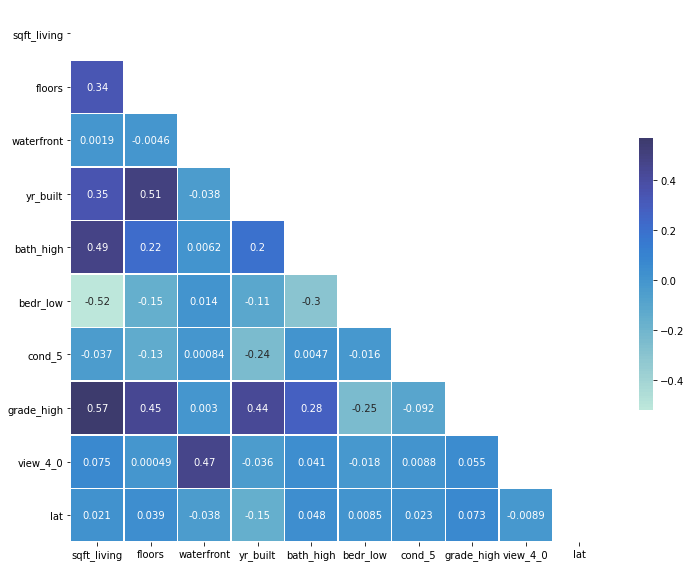

In [159]:
corr = df10[['sqft_living','floors','waterfront','yr_built','bath_high','bedr_low','cond_5','grade_high','view_4_0','lat']].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

None of our features are highly collinear (>.75 correlation coefficient) with each other.

In [160]:
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     3154.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:50   Log-Likelihood:            -2.7415e+05
No. Observations:               20742   AIC:                         5.483e+05
Df Residuals:                   20729   BIC:                         5.484e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.425e+07   9.95e+05    -24.369      0.000   -2.62e+07   -2.23e+07
sqft_living   148.0497      1.777     83.312      0.000     144.567     151.533
sqft_lot        0.1732      0.024      7.192      0.000       0.126       0.220
floors       3.233e+04   2122.265     15.234      0.000    2.82e+04    3.65e+04
waterfront   1.585e+05   1.92e+04      8.267      0.000    1.21e+05    1.96e+05
yr_built    -1581.0705     43.116    -36.670      0.000   -1665.581   -1496.560
lat          5.611e+05   6834.506     82.095      0.000    5.48e+05    5.74e+05
long        -6115.8053   7512.650     -0.814      0.416   -2.08e+04    8609.579
bath_high     3.15e+04   2970.306     10.603      0.000    2.57e+04    3.73e+04
cond_5       4.144e+04   3587.058     11.553      0.000    3.44e+04    4.85e+04
bedr_low     2.179e+04   2229.617      9.771      0.000    1.74e+04    2.62e+04
grade_high   1.121e+05   2461.302     45.551      0.000    1.07e+05    1.17e+05
view_4_0     1.699e+05   1.14e+04     14.873      0.000    1.47e+05    1.92e+05
==============================================================================
Omnibus:                     2224.677   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4621.307
Skew:                           0.683   Prob(JB):                         0.00
Kurtosis:                       4.866   Cond. No.                     4.60e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.6e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [161]:
df10.head(3)

,price,sqft_living,sqft_lot,floors,waterfront,yr_built,lat,long,bath_high,cond_5,bedr_low,grade_high,view_4_0
0,221900.0,1180,5650,1.0,0.0,1955,47.5112,-122.257,0,0,1,0,0
1,538000.0,2570,7242,2.0,0.0,1951,47.7210,-122.319,0,0,1,0,0
2,180000.0,770,10000,1.0,0.0,1933,47.7379,-122.233,0,0,1,0,0


In [162]:
df10.describe()

,price,sqft_living,sqft_lot,floors,waterfront,yr_built,lat,long,bath_high,cond_5,bedr_low,grade_high,view_4_0
count,2.074200e+04,20742.000000,2.074200e+04,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000
mean,4.871982e+05,1997.125108,1.468612e+04,1.480233,0.002989,1970.867949,47.557738,-122.213311,0.152878,0.076560,0.598207,0.456465,0.008533
std,2.236077e+05,797.480005,4.005326e+04,0.536993,0.054592,29.202482,0.140411,0.142026,0.359879,0.265898,0.490272,0.498113,0.091984
min,7.800000e+04,370.000000,5.200000e+02,1.000000,0.000000,1900.000000,47.155900,-122.519000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.170000e+05,1400.000000,5.000000e+03,1.000000,0.000000,1951.000000,47.462750,-122.330000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.400000e+05,1870.000000,7.520000e+03,1.000000,0.000000,1974.000000,47.568100,-122.231000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.125000e+05,2460.000000,1.040000e+04,2.000000,0.000000,1996.000000,47.679500,-122.123000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.260000e+06,7480.000000,1.651359e+06,3.500000,1.000000,2015.000000,47.777600,-121.315000,1.000000,1.000000,1.000000,1.000000,1.000000


In [163]:
bins=[47.1559,47.46275,47.6795,47.7776]
bins_lat=pd.cut(df10['lat'], bins)
bins_lat=bins_lat.cat.as_ordered()

In [164]:
df10.lat=bins_lat
df10.lat=df10.lat.cat.codes
lat_dummies=pd.get_dummies(bins_lat, prefix='lat')
df10=pd.concat([df10,lat_dummies], axis=1)

In [165]:
#df10.drop(['lat'], axis=1,inplace=True)
df10.rename(columns={'lat_(47.156, 47.463]': 'south'},inplace=True)
df10.rename(columns={'lat_(47.463, 47.68]': 'middle_latitude'},inplace=True)
df10.rename(columns={'lat_(47.68, 47.778]': 'north'},inplace=True)
df10.head()

,price,sqft_living,sqft_lot,floors,waterfront,yr_built,lat,long,bath_high,cond_5,bedr_low,grade_high,view_4_0,south,middle_latitude,north
0,221900.0,1180,5650,1.0,0.0,1955,1,-122.257,0,0,1,0,0,0,1,0
1,538000.0,2570,7242,2.0,0.0,1951,2,-122.319,0,0,1,0,0,0,0,1
2,180000.0,770,10000,1.0,0.0,1933,2,-122.233,0,0,1,0,0,0,0,1
3,604000.0,1960,5000,1.0,0.0,1965,1,-122.393,1,1,0,0,0,0,1,0
4,510000.0,1680,8080,1.0,0.0,1987,1,-122.045,0,0,1,1,0,0,1,0


In [166]:
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     2740.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:51   Log-Likelihood:            -2.7406e+05
No. Observations:               20742   AIC:                         5.481e+05
Df Residuals:                   20727   BIC:                         5.483e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.994e+06   8.97e+05     -5.567      0.000   -6.75e+06   -3.24e+06
sqft_living       151.9410      1.770     85.856      0.000     148.472     155.410
sqft_lot            0.2586      0.024     10.731      0.000       0.211       0.306
floors           2.468e+04   2127.761     11.597      0.000    2.05e+04    2.88e+04
waterfront       1.664e+05   1.91e+04      8.717      0.000    1.29e+05    2.04e+05
yr_built        -1293.5263     43.976    -29.414      0.000   -1379.723   -1207.329
lat               3.47e+05   8.19e+04      4.239      0.000    1.87e+05    5.07e+05
long            -6.495e+04   7531.495     -8.624      0.000   -7.97e+04   -5.02e+04
bath_high         2.18e+04   2965.945      7.352      0.000     1.6e+04    2.76e+04
cond_5           3.993e+04   3571.142     11.180      0.000    3.29e+04    4.69e+04
bedr_low         2.258e+04   2219.735     10.174      0.000    1.82e+04    2.69e+04
grade_high       1.088e+05   2458.786     44.247      0.000    1.04e+05    1.14e+05
view_4_0         1.539e+05   1.14e+04     13.535      0.000    1.32e+05    1.76e+05
south           -4.629e+05   9.72e+04     -4.763      0.000   -6.53e+05   -2.72e+05
middle_latitude -6.168e+05   1.21e+05     -5.095      0.000   -8.54e+05   -3.79e+05
north           -9.835e+05   1.83e+05     -5.382      0.000   -1.34e+06   -6.25e+05
==============================================================================
Omnibus:                     1682.185   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3452.095
Skew:                           0.543   Prob(JB):                         0.00
Kurtosis:                       4.678   Cond. No.                     2.25e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.47e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [167]:
df10.drop(['south'], axis=1,inplace=True)

In [168]:
df10.drop(['lat'], axis=1,inplace=True)

In [169]:
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     2951.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:51   Log-Likelihood:            -2.7406e+05
No. Observations:               20742   AIC:                         5.481e+05
Df Residuals:                   20728   BIC:                         5.483e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.428e+06   9.56e+05     -5.679      0.000    -7.3e+06   -3.55e+06
sqft_living       151.9406      1.770     85.856      0.000     148.472     155.409
sqft_lot            0.2584      0.024     10.724      0.000       0.211       0.306
floors           2.471e+04   2127.465     11.613      0.000    2.05e+04    2.89e+04
waterfront       1.664e+05   1.91e+04      8.717      0.000    1.29e+05    2.04e+05
yr_built        -1294.2897     43.967    -29.437      0.000   -1380.469   -1208.110
long            -6.473e+04   7527.098     -8.600      0.000   -7.95e+04      -5e+04
bath_high        2.181e+04   2965.924      7.353      0.000     1.6e+04    2.76e+04
cond_5           3.992e+04   3571.109     11.178      0.000    3.29e+04    4.69e+04
bedr_low          2.26e+04   2219.664     10.180      0.000    1.82e+04    2.69e+04
grade_high       1.088e+05   2458.735     44.244      0.000    1.04e+05    1.14e+05
view_4_0         1.539e+05   1.14e+04     13.536      0.000    1.32e+05    1.76e+05
middle_latitude   1.93e+05   2391.400     80.725      0.000    1.88e+05    1.98e+05
north            1.733e+05   2656.898     65.229      0.000    1.68e+05    1.79e+05
==============================================================================
Omnibus:                     1682.221   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3451.825
Skew:                           0.543   Prob(JB):                         0.00
Kurtosis:                       4.678   Cond. No.                     4.43e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [170]:
df10.describe()

,price,sqft_living,sqft_lot,floors,waterfront,yr_built,long,bath_high,cond_5,bedr_low,grade_high,view_4_0,middle_latitude,north
count,2.074200e+04,20742.000000,2.074200e+04,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000
mean,4.871982e+05,1997.125108,1.468612e+04,1.480233,0.002989,1970.867949,-122.213311,0.152878,0.076560,0.598207,0.456465,0.008533,0.500193,0.249783
std,2.236077e+05,797.480005,4.005326e+04,0.536993,0.054592,29.202482,0.142026,0.359879,0.265898,0.490272,0.498113,0.091984,0.500012,0.432898
min,7.800000e+04,370.000000,5.200000e+02,1.000000,0.000000,1900.000000,-122.519000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.170000e+05,1400.000000,5.000000e+03,1.000000,0.000000,1951.000000,-122.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.400000e+05,1870.000000,7.520000e+03,1.000000,0.000000,1974.000000,-122.231000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,6.125000e+05,2460.000000,1.040000e+04,2.000000,0.000000,1996.000000,-122.123000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.260000e+06,7480.000000,1.651359e+06,3.500000,1.000000,2015.000000,-121.315000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [171]:
bins=[-122.519,-122.33,-122.123,-121.315]
bins_long=pd.cut(df10['long'], bins)
bins_long=bins_long.cat.as_ordered()

In [172]:
df10.long=bins_long
df10.long=df10.long.cat.codes
long_dummies=pd.get_dummies(bins_long, prefix='long')
df10=pd.concat([df10,long_dummies], axis=1)

In [173]:
df10.head(3)

,price,sqft_living,sqft_lot,floors,waterfront,yr_built,long,bath_high,cond_5,bedr_low,grade_high,view_4_0,middle_latitude,north,"long_(-122.519, -122.33]","long_(-122.33, -122.123]","long_(-122.123, -121.315]"
0,221900.0,1180,5650,1.0,0.0,1955,1,0,0,1,0,0,1,0,0,1,0
1,538000.0,2570,7242,2.0,0.0,1951,1,0,0,1,0,0,0,1,0,1,0
2,180000.0,770,10000,1.0,0.0,1933,1,0,0,1,0,0,0,1,0,1,0


In [174]:
df10.drop(['long'], axis=1,inplace=True)
df10.rename(columns={'long_(-122.519, -122.33]': 'west'},inplace=True)
df10.rename(columns={'long_(-122.33, -122.123]': 'middle_longtitude'},inplace=True)
df10.rename(columns={'long_(-122.123, -121.315]': 'east'},inplace=True)
df10.head()

,price,sqft_living,sqft_lot,floors,waterfront,yr_built,bath_high,cond_5,bedr_low,grade_high,view_4_0,middle_latitude,north,west,middle_longtitude,east
0,221900.0,1180,5650,1.0,0.0,1955,0,0,1,0,0,1,0,0,1,0
1,538000.0,2570,7242,2.0,0.0,1951,0,0,1,0,0,0,1,0,1,0
2,180000.0,770,10000,1.0,0.0,1933,0,0,1,0,0,0,1,0,1,0
3,604000.0,1960,5000,1.0,0.0,1965,1,1,0,0,0,1,0,1,0,0
4,510000.0,1680,8080,1.0,0.0,1987,0,0,1,1,0,1,0,0,0,1


In [175]:
df10.drop(['middle_longtitude'], axis=1,inplace=True)

In [176]:
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2730.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:52   Log-Likelihood:            -2.7408e+05
No. Observations:               20742   AIC:                         5.482e+05
Df Residuals:                   20727   BIC:                         5.483e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.681e+06   8.37e+04     32.034      0.000    2.52e+06    2.85e+06
sqft_living       150.3418      1.770     84.947      0.000     146.873     153.811
sqft_lot            0.2188      0.024      9.053      0.000       0.171       0.266
floors           2.545e+04   2133.719     11.929      0.000    2.13e+04    2.96e+04
waterfront       1.701e+05   1.91e+04      8.903      0.000    1.33e+05    2.08e+05
yr_built        -1394.7153     43.054    -32.394      0.000   -1479.105   -1310.325
bath_high        2.354e+04   2965.471      7.938      0.000    1.77e+04    2.94e+04
cond_5           3.972e+04   3575.579     11.110      0.000    3.27e+04    4.67e+04
bedr_low         2.228e+04   2226.027     10.010      0.000    1.79e+04    2.66e+04
grade_high       1.096e+05   2460.078     44.540      0.000    1.05e+05    1.14e+05
view_4_0         1.545e+05   1.14e+04     13.569      0.000    1.32e+05    1.77e+05
middle_latitude   1.91e+05   2398.958     79.631      0.000    1.86e+05    1.96e+05
north            1.735e+05   2662.355     65.166      0.000    1.68e+05    1.79e+05
west             1.117e+04   2332.187      4.788      0.000    6595.411    1.57e+04
east             1499.5471   2439.493      0.615      0.539   -3282.051    6281.145
==============================================================================
Omnibus:                     1800.486   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3705.723
Skew:                           0.574   Prob(JB):                         0.00
Kurtosis:                       4.723   Cond. No.                     3.88e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [177]:
#East is statistically insignificant.
df10.drop(['east'], axis=1,inplace=True)

In [178]:
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2940.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:52   Log-Likelihood:            -2.7409e+05
No. Observations:               20742   AIC:                         5.482e+05
Df Residuals:                   20728   BIC:                         5.483e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         2.67e+06   8.16e+04     32.714      0.000    2.51e+06    2.83e+06
sqft_living       150.4509      1.761     85.441      0.000     146.999     153.902
sqft_lot            0.2219      0.024      9.384      0.000       0.176       0.268
floors           2.545e+04   2133.667     11.926      0.000    2.13e+04    2.96e+04
waterfront         1.7e+05   1.91e+04      8.898      0.000    1.33e+05    2.08e+05
yr_built        -1388.8482     41.982    -33.082      0.000   -1471.137   -1306.559
bath_high        2.344e+04   2960.957      7.917      0.000    1.76e+04    2.92e+04
cond_5           3.973e+04   3575.481     11.113      0.000    3.27e+04    4.67e+04
bedr_low         2.233e+04   2224.701     10.037      0.000     1.8e+04    2.67e+04
grade_high       1.096e+05   2459.973     44.538      0.000    1.05e+05    1.14e+05
view_4_0         1.545e+05   1.14e+04     13.568      0.000    1.32e+05    1.77e+05
middle_latitude  1.912e+05   2390.028     79.982      0.000    1.86e+05    1.96e+05
north            1.735e+05   2662.300     65.165      0.000    1.68e+05    1.79e+05
west             1.081e+04   2257.344      4.787      0.000    6381.926    1.52e+04
==============================================================================
Omnibus:                     1786.756   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3672.287
Skew:                           0.571   Prob(JB):                         0.00
Kurtosis:                       4.716   Cond. No.                     3.78e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

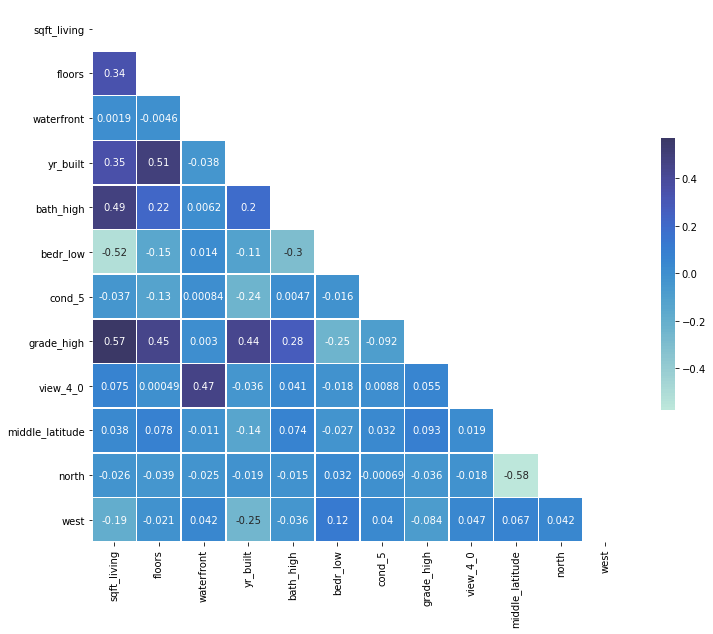

In [179]:
corr = df10[['sqft_living','floors','waterfront','yr_built','bath_high','bedr_low','cond_5','grade_high','view_4_0','middle_latitude','north','west']].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

Still no major correlations between our independent variables, which is a good sign. We concluded that there are no
multicollinearity issues despite the condition number indicating that this could be the case.

In [180]:
#make X,y to put in the train-test split
y=df10.price
X=df10.drop('price', axis=1)
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))
linreg=LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train=linreg.predict(X_train)
y_hat_test=linreg.predict(X_test)

y_hat_test
y_test

train_mse=mean_squared_error(y_train, y_hat_train)
test_mse=mean_squared_error(y_test, y_hat_test)

print('Train Mean Squared Error {}'.format(train_mse))
print('Test Mean Squared Error {}'.format(test_mse))
print('Root Train Mean Squared Error {}'.format(train_mse**0.5))
print('Root Test Mean Squared Error {}'.format(test_mse**0.5))

16593 4149
Train Mean Squared Error 17698330596.969227
Test Mean Squared Error 17154814424.68709
Root Train Mean Squared Error 133035.0728077721
Root Test Mean Squared Error 130976.38880610158


The model above appears to be our final model, but before making this conclusion, let's observe some changes that could help. The regions (i.e. north) seem to help our model, but do they? Let's see what our model would look like it we removed those.

In [181]:
df_alternate10=df10

In [182]:
df_alternate10.drop(['middle_latitude','north','west'], axis=1,inplace=True)

In [183]:
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     2343.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:51:53   Log-Likelihood:            -2.7708e+05
No. Observations:               20742   AIC:                         5.542e+05
Df Residuals:                   20731   BIC:                         5.543e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.658e+06   8.74e+04     53.298      0.000    4.49e+06    4.83e+06
sqft_living   149.6657      2.018     74.175      0.000     145.711     153.621
sqft_lot       -0.0134      0.027     -0.494      0.621      -0.066       0.040
floors       4.763e+04   2424.183     19.646      0.000    4.29e+04    5.24e+04
waterfront   9.612e+04    2.2e+04      4.359      0.000    5.29e+04    1.39e+05
yr_built    -2349.5882     45.301    -51.866      0.000   -2438.381   -2260.795
bath_high    4.359e+04   3401.941     12.814      0.000    3.69e+04    5.03e+04
cond_5       3.629e+04   4130.042      8.786      0.000    2.82e+04    4.44e+04
bedr_low     3.001e+04   2564.983     11.699      0.000     2.5e+04     3.5e+04
grade_high   1.345e+05   2813.435     47.806      0.000    1.29e+05     1.4e+05
view_4_0     1.634e+05   1.31e+04     12.432      0.000    1.38e+05    1.89e+05
==============================================================================
Omnibus:                     1025.797   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1475.889
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                       3.930   Cond. No.                     3.51e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [184]:
#make X,y to put in the train-test split
y=df_alternate10.price
X=df_alternate10.drop('price', axis=1)
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))
linreg=LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train=linreg.predict(X_train)
y_hat_test=linreg.predict(X_test)

y_hat_test
y_test

train_mse=mean_squared_error(y_train, y_hat_train)
test_mse=mean_squared_error(y_test, y_hat_test)

print('Train Mean Squared Error {}'.format(train_mse))
print('Test Mean Squared Error {}'.format(test_mse))
print('Root Train Mean Squared Error {}'.format(train_mse**0.5))
print('Root Test Mean Squared Error {}'.format(test_mse**0.5))

16593 4149
Train Mean Squared Error 23702146793.477333
Test Mean Squared Error 22583987499.02714
Root Train Mean Squared Error 153955.0154865938
Root Test Mean Squared Error 150279.69756100504


When we remove our regions, we get a lower R-Squared and higher RMSE. In both cases, all of our p-values are much less than 0.05. So, it is in our best interests to keep the regions of the county from the latitude and longitude bins. As a result, our best model is the one with .648 R-Squared and 130,976 Root Test Mean Squared Error.

And, finally, let's compare our RMSE to our initial model (based on df_data), which was before any data cleaning. We would certainly hope for significant reductions in RMSE since that stage.

In [185]:
y=df_data.price
X=df_data.drop('price', axis=1)
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

linreg=LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train=linreg.predict(X_train)
y_hat_test=linreg.predict(X_test)

y_hat_test
y_test

train_mse=mean_squared_error(y_train, y_hat_train)
test_mse=mean_squared_error(y_test, y_hat_test)

print('Train Mean Squared Error {}'.format(train_mse))
print('Test Mean Squared Error {}'.format(test_mse))
print('Root Train Mean Squared Error {}'.format(train_mse**0.5))
print('Root Test Mean Squared Error {}'.format(test_mse**0.5))

17277 4320
Train Mean Squared Error 40418932102.46232
Test Mean Squared Error 39671607791.23816
Root Train Mean Squared Error 201044.6022713923
Root Test Mean Squared Error 199177.3275030021


Fortunately, there is a significant reduction in RMSE since that initial model.